[View in Colaboratory](https://colab.research.google.com/github/sungreong/GAN/blob/master/AAE_MNIST_KERAS.ipynb)

In [0]:
from __future__ import print_function, division

In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt

import numpy as np

https://ratsgo.github.io/generative%20model/2018/01/28/VAEs/

https://github.com/hwalsuklee/tensorflow-mnist-AAE/blob/master/run_main.py


![대체 텍스트](https://preview.ibb.co/ntzqv8/AA.png)


In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

class AdversarialAutoencoder():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 10

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the encoder / decoder
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=self.img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        encoded_repr = self.encoder(img)
        
        reconstructed_img = self.decoder(encoded_repr)

        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator determines validity of the encoding
        validity = self.discriminator(encoded_repr)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)


    def build_encoder(self):
        
        # Encoder
        
        img = Input(shape=self.img_shape) # (28 , 28 ,1)

        h = Flatten()(img)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        mu = Dense(self.latent_dim)(h) # latent_dim = 10 
        log_var = Dense(self.latent_dim)(h) # latent_dim = 10  
        latent_repr = merge([mu, log_var],
                mode=lambda p: p[0] + K.random_normal(K.shape(p[0])) * K.exp(p[1] / 2),
                output_shape=lambda p: p[0])
        #  mu + epsilon * exp(log(var) /2 ) ## reparmeterization trick?

        return Model(inputs=img, outputs=latent_repr)

    def build_decoder(self):

        model = Sequential()

        model.add(Dense(512, input_dim=self.latent_dim)) # 10
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        z = Input(shape=(self.latent_dim,)) # (10, )
        img = model(z)

        return Model( inputs=z, outputs = img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation="sigmoid"))
        model.summary()

        encoded_repr = Input(shape=(self.latent_dim, ))
        validity = model(encoded_repr)

        return Model(inputs = encoded_repr, outputs = validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):


            #  Train Discriminator
 

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            latent_fake = self.encoder.predict(imgs)
            latent_real = np.random.normal(size=(batch_size, self.latent_dim))

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(latent_real, valid)
            d_loss_fake = self.discriminator.train_on_batch(latent_fake, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            #  Train Generator


            # Train the generator
            g_loss = self.adversarial_autoencoder.train_on_batch(imgs, [imgs, valid]) ## multiple outputs 

            # Plot the progress
            print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5

        z = np.random.normal(size=(r*c, self.latent_dim))
        gen_imgs = self.decoder.predict(z) ## decoder 에서 이미지 출력을 한다 ##

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("mnist_%d.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "%s.json" % model_name
            weights_path = "%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "aae_generator")
        save(self.discriminator, "aae_discriminator")




In [5]:
if __name__ == '__main__':
    aae = AdversarialAutoencoder()
    aae.train(epochs=10000, batch_size=32, sample_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.805113, acc: 31.25%] [G loss: 0.936885, mse: 0.937257]
1 [D loss: 0.731453, acc: 37.50%] [G loss: 0.920982, mse: 0.921269]
2 [D loss: 0.680962, acc: 51.56%] [G loss: 0.891402, mse: 0.891561]
3 [D loss: 0.582258, acc: 84.38%] [G loss: 0.839199, mse: 0.838867]
4 [D loss: 0.414781, acc: 85.94%] [G loss: 0.747248, mse: 0.745892]
5 [D loss: 0.321955, acc: 89.06%] [G loss: 0.633271, mse: 0.630291]
6 [D loss: 0.314485, acc: 90.62%] [G loss: 0.530189, mse: 0.525781]
7 [D loss: 0.280892, acc: 92.19%] [G loss: 0.425850, mse: 0.420409]
8 [D loss: 0.279832, acc: 87.50%] [G loss: 0.380570, mse: 0.374571]
9 [D loss: 0.260631, acc: 93.75%] [G loss: 0.292833, mse: 0.286485]
10 [D loss: 0.240233, acc: 100.00%] [G loss: 0.283675, mse: 0.277178]
11 [D loss: 0.200052, acc: 100.00%] [G loss: 0.315367, mse: 0.309447]
12 [D loss: 0.191511, acc: 96.88%] [G loss: 0.249515, mse: 0.243569]
13 [D loss: 0.189090, acc: 100.00%] [G loss: 0.278603, mse: 0.272911]
14 [D loss: 0.183938, acc: 100.00%] [G lo

129 [D loss: 0.196337, acc: 90.62%] [G loss: 0.155283, mse: 0.149081]
130 [D loss: 0.504427, acc: 76.56%] [G loss: 0.154403, mse: 0.149946]
131 [D loss: 0.193446, acc: 92.19%] [G loss: 0.175125, mse: 0.163921]
132 [D loss: 0.258584, acc: 92.19%] [G loss: 0.154197, mse: 0.146743]
133 [D loss: 0.235458, acc: 87.50%] [G loss: 0.144743, mse: 0.139184]
134 [D loss: 0.236675, acc: 87.50%] [G loss: 0.153379, mse: 0.147064]
135 [D loss: 0.253543, acc: 89.06%] [G loss: 0.160500, mse: 0.154235]
136 [D loss: 0.269169, acc: 89.06%] [G loss: 0.158300, mse: 0.153310]
137 [D loss: 0.232907, acc: 90.62%] [G loss: 0.142697, mse: 0.136069]
138 [D loss: 0.194660, acc: 92.19%] [G loss: 0.149906, mse: 0.143970]
139 [D loss: 0.226202, acc: 90.62%] [G loss: 0.146546, mse: 0.141271]
140 [D loss: 0.223824, acc: 96.88%] [G loss: 0.135847, mse: 0.129374]
141 [D loss: 0.216370, acc: 89.06%] [G loss: 0.129540, mse: 0.123237]
142 [D loss: 0.264072, acc: 95.31%] [G loss: 0.134235, mse: 0.128605]
143 [D loss: 0.17966

255 [D loss: 0.051636, acc: 98.44%] [G loss: 0.118443, mse: 0.111590]
256 [D loss: 0.053145, acc: 100.00%] [G loss: 0.139422, mse: 0.133040]
257 [D loss: 0.057399, acc: 98.44%] [G loss: 0.126895, mse: 0.120885]
258 [D loss: 0.044685, acc: 100.00%] [G loss: 0.140503, mse: 0.133526]
259 [D loss: 0.043679, acc: 100.00%] [G loss: 0.142738, mse: 0.136663]
260 [D loss: 0.047781, acc: 100.00%] [G loss: 0.118129, mse: 0.109755]
261 [D loss: 0.044861, acc: 100.00%] [G loss: 0.114380, mse: 0.107527]
262 [D loss: 0.050257, acc: 100.00%] [G loss: 0.128371, mse: 0.121473]
263 [D loss: 0.046681, acc: 100.00%] [G loss: 0.140994, mse: 0.135008]
264 [D loss: 0.050084, acc: 100.00%] [G loss: 0.118525, mse: 0.111538]
265 [D loss: 0.036263, acc: 100.00%] [G loss: 0.133972, mse: 0.127354]
266 [D loss: 0.044638, acc: 100.00%] [G loss: 0.134997, mse: 0.128808]
267 [D loss: 0.049979, acc: 100.00%] [G loss: 0.126724, mse: 0.120697]
268 [D loss: 0.034958, acc: 100.00%] [G loss: 0.128623, mse: 0.121215]
269 [D l

381 [D loss: 0.016169, acc: 100.00%] [G loss: 0.129393, mse: 0.121464]
382 [D loss: 0.021442, acc: 100.00%] [G loss: 0.123803, mse: 0.117293]
383 [D loss: 0.011681, acc: 100.00%] [G loss: 0.123805, mse: 0.115360]
384 [D loss: 0.013764, acc: 100.00%] [G loss: 0.110907, mse: 0.104333]
385 [D loss: 0.030341, acc: 100.00%] [G loss: 0.119267, mse: 0.113304]
386 [D loss: 0.013930, acc: 100.00%] [G loss: 0.118312, mse: 0.110430]
387 [D loss: 0.015923, acc: 100.00%] [G loss: 0.117906, mse: 0.110611]
388 [D loss: 0.015177, acc: 100.00%] [G loss: 0.120654, mse: 0.113560]
389 [D loss: 0.011278, acc: 100.00%] [G loss: 0.125117, mse: 0.117079]
390 [D loss: 0.037515, acc: 98.44%] [G loss: 0.125642, mse: 0.118453]
391 [D loss: 0.011670, acc: 100.00%] [G loss: 0.115340, mse: 0.106840]
392 [D loss: 0.016967, acc: 100.00%] [G loss: 0.122571, mse: 0.114568]
393 [D loss: 0.012902, acc: 100.00%] [G loss: 0.118733, mse: 0.110683]
394 [D loss: 0.024475, acc: 100.00%] [G loss: 0.124566, mse: 0.117785]
395 [D 

503 [D loss: 0.009012, acc: 100.00%] [G loss: 0.129279, mse: 0.121784]
504 [D loss: 0.006832, acc: 100.00%] [G loss: 0.108177, mse: 0.099425]
505 [D loss: 0.023721, acc: 98.44%] [G loss: 0.117136, mse: 0.108983]
506 [D loss: 0.014288, acc: 100.00%] [G loss: 0.123210, mse: 0.116245]
507 [D loss: 0.008378, acc: 100.00%] [G loss: 0.114932, mse: 0.107205]
508 [D loss: 0.014708, acc: 100.00%] [G loss: 0.117764, mse: 0.111180]
509 [D loss: 0.006552, acc: 100.00%] [G loss: 0.134096, mse: 0.124955]
510 [D loss: 0.019652, acc: 100.00%] [G loss: 0.118010, mse: 0.109929]
511 [D loss: 0.006378, acc: 100.00%] [G loss: 0.110579, mse: 0.102164]
512 [D loss: 0.006127, acc: 100.00%] [G loss: 0.115271, mse: 0.106515]
513 [D loss: 0.012511, acc: 100.00%] [G loss: 0.124769, mse: 0.116843]
514 [D loss: 0.007314, acc: 100.00%] [G loss: 0.125036, mse: 0.116461]
515 [D loss: 0.011244, acc: 100.00%] [G loss: 0.127689, mse: 0.120732]
516 [D loss: 0.008018, acc: 100.00%] [G loss: 0.142210, mse: 0.134335]
517 [D 

625 [D loss: 0.006861, acc: 100.00%] [G loss: 0.115136, mse: 0.106118]
626 [D loss: 0.009154, acc: 100.00%] [G loss: 0.126251, mse: 0.117629]
627 [D loss: 0.007216, acc: 100.00%] [G loss: 0.119296, mse: 0.111059]
628 [D loss: 0.009612, acc: 100.00%] [G loss: 0.120292, mse: 0.110800]
629 [D loss: 0.006987, acc: 100.00%] [G loss: 0.118589, mse: 0.110450]
630 [D loss: 0.006131, acc: 100.00%] [G loss: 0.109557, mse: 0.099836]
631 [D loss: 0.006074, acc: 100.00%] [G loss: 0.111622, mse: 0.102736]
632 [D loss: 0.007309, acc: 100.00%] [G loss: 0.111128, mse: 0.101992]
633 [D loss: 0.010304, acc: 100.00%] [G loss: 0.110239, mse: 0.101514]
634 [D loss: 0.009712, acc: 100.00%] [G loss: 0.111653, mse: 0.102821]
635 [D loss: 0.006993, acc: 100.00%] [G loss: 0.132868, mse: 0.123915]
636 [D loss: 0.008159, acc: 100.00%] [G loss: 0.107503, mse: 0.099220]
637 [D loss: 0.009727, acc: 100.00%] [G loss: 0.110904, mse: 0.103103]
638 [D loss: 0.014240, acc: 100.00%] [G loss: 0.140465, mse: 0.133330]
639 [D

751 [D loss: 0.008989, acc: 100.00%] [G loss: 0.108630, mse: 0.099574]
752 [D loss: 0.010636, acc: 100.00%] [G loss: 0.108704, mse: 0.100411]
753 [D loss: 0.005773, acc: 100.00%] [G loss: 0.118359, mse: 0.109624]
754 [D loss: 0.010451, acc: 100.00%] [G loss: 0.102311, mse: 0.092613]
755 [D loss: 0.020084, acc: 98.44%] [G loss: 0.102889, mse: 0.094245]
756 [D loss: 0.006246, acc: 100.00%] [G loss: 0.112501, mse: 0.103583]
757 [D loss: 0.033295, acc: 98.44%] [G loss: 0.106864, mse: 0.097933]
758 [D loss: 0.007340, acc: 100.00%] [G loss: 0.120413, mse: 0.110159]
759 [D loss: 0.037949, acc: 98.44%] [G loss: 0.114886, mse: 0.105865]
760 [D loss: 0.007100, acc: 100.00%] [G loss: 0.112726, mse: 0.102376]
761 [D loss: 0.013410, acc: 100.00%] [G loss: 0.115846, mse: 0.106669]
762 [D loss: 0.018473, acc: 98.44%] [G loss: 0.129462, mse: 0.119977]
763 [D loss: 0.010394, acc: 100.00%] [G loss: 0.104131, mse: 0.094756]
764 [D loss: 0.008324, acc: 100.00%] [G loss: 0.113831, mse: 0.104463]
765 [D los

873 [D loss: 0.013845, acc: 100.00%] [G loss: 0.110527, mse: 0.101749]
874 [D loss: 0.014664, acc: 100.00%] [G loss: 0.110647, mse: 0.101055]
875 [D loss: 0.025650, acc: 100.00%] [G loss: 0.122239, mse: 0.112351]
876 [D loss: 0.006056, acc: 100.00%] [G loss: 0.115770, mse: 0.107206]
877 [D loss: 0.007033, acc: 100.00%] [G loss: 0.113789, mse: 0.104086]
878 [D loss: 0.007527, acc: 100.00%] [G loss: 0.111955, mse: 0.101417]
879 [D loss: 0.006685, acc: 100.00%] [G loss: 0.112140, mse: 0.103273]
880 [D loss: 0.012447, acc: 100.00%] [G loss: 0.092791, mse: 0.083245]
881 [D loss: 0.007586, acc: 100.00%] [G loss: 0.110879, mse: 0.102002]
882 [D loss: 0.006668, acc: 100.00%] [G loss: 0.113393, mse: 0.103116]
883 [D loss: 0.006662, acc: 100.00%] [G loss: 0.114131, mse: 0.104856]
884 [D loss: 0.022545, acc: 100.00%] [G loss: 0.129470, mse: 0.120922]
885 [D loss: 0.010125, acc: 100.00%] [G loss: 0.106189, mse: 0.097190]
886 [D loss: 0.002441, acc: 100.00%] [G loss: 0.105045, mse: 0.094288]
887 [D

1001 [D loss: 0.003692, acc: 100.00%] [G loss: 0.105092, mse: 0.095083]
1002 [D loss: 0.026449, acc: 98.44%] [G loss: 0.107391, mse: 0.097804]
1003 [D loss: 0.026178, acc: 98.44%] [G loss: 0.089437, mse: 0.078011]
1004 [D loss: 0.024513, acc: 98.44%] [G loss: 0.104200, mse: 0.095006]
1005 [D loss: 0.030303, acc: 98.44%] [G loss: 0.087807, mse: 0.078277]
1006 [D loss: 0.015641, acc: 100.00%] [G loss: 0.107729, mse: 0.099124]
1007 [D loss: 0.012247, acc: 100.00%] [G loss: 0.118121, mse: 0.107690]
1008 [D loss: 0.022178, acc: 98.44%] [G loss: 0.105750, mse: 0.095433]
1009 [D loss: 0.010473, acc: 100.00%] [G loss: 0.118630, mse: 0.106937]
1010 [D loss: 0.033189, acc: 98.44%] [G loss: 0.119994, mse: 0.110916]
1011 [D loss: 0.013724, acc: 100.00%] [G loss: 0.129900, mse: 0.119561]
1012 [D loss: 0.005722, acc: 100.00%] [G loss: 0.112691, mse: 0.102845]
1013 [D loss: 0.010592, acc: 100.00%] [G loss: 0.103071, mse: 0.094070]
1014 [D loss: 0.025572, acc: 98.44%] [G loss: 0.126976, mse: 0.115043]

1122 [D loss: 0.018138, acc: 100.00%] [G loss: 0.117574, mse: 0.108684]
1123 [D loss: 0.032344, acc: 96.88%] [G loss: 0.118947, mse: 0.109085]
1124 [D loss: 0.005924, acc: 100.00%] [G loss: 0.117009, mse: 0.105303]
1125 [D loss: 0.014688, acc: 100.00%] [G loss: 0.113929, mse: 0.103690]
1126 [D loss: 0.006313, acc: 100.00%] [G loss: 0.112175, mse: 0.101551]
1127 [D loss: 0.010783, acc: 100.00%] [G loss: 0.099201, mse: 0.088927]
1128 [D loss: 0.016041, acc: 100.00%] [G loss: 0.120311, mse: 0.110574]
1129 [D loss: 0.010512, acc: 100.00%] [G loss: 0.101193, mse: 0.090032]
1130 [D loss: 0.004616, acc: 100.00%] [G loss: 0.114925, mse: 0.104888]
1131 [D loss: 0.008955, acc: 100.00%] [G loss: 0.122002, mse: 0.111825]
1132 [D loss: 0.011157, acc: 100.00%] [G loss: 0.123915, mse: 0.113873]
1133 [D loss: 0.009729, acc: 100.00%] [G loss: 0.117366, mse: 0.107945]
1134 [D loss: 0.029698, acc: 98.44%] [G loss: 0.122210, mse: 0.112738]
1135 [D loss: 0.008293, acc: 100.00%] [G loss: 0.133308, mse: 0.12

1243 [D loss: 0.025186, acc: 100.00%] [G loss: 0.102615, mse: 0.092210]
1244 [D loss: 0.019118, acc: 98.44%] [G loss: 0.107994, mse: 0.097926]
1245 [D loss: 0.016604, acc: 100.00%] [G loss: 0.114685, mse: 0.103930]
1246 [D loss: 0.042900, acc: 98.44%] [G loss: 0.104595, mse: 0.091702]
1247 [D loss: 0.028654, acc: 98.44%] [G loss: 0.120620, mse: 0.109437]
1248 [D loss: 0.011945, acc: 100.00%] [G loss: 0.125516, mse: 0.114949]
1249 [D loss: 0.004475, acc: 100.00%] [G loss: 0.120296, mse: 0.108464]
1250 [D loss: 0.006011, acc: 100.00%] [G loss: 0.114538, mse: 0.104077]
1251 [D loss: 0.019177, acc: 100.00%] [G loss: 0.113722, mse: 0.102824]
1252 [D loss: 0.016441, acc: 100.00%] [G loss: 0.109592, mse: 0.099142]
1253 [D loss: 0.029798, acc: 98.44%] [G loss: 0.125760, mse: 0.116601]
1254 [D loss: 0.003671, acc: 100.00%] [G loss: 0.095678, mse: 0.084075]
1255 [D loss: 0.013545, acc: 100.00%] [G loss: 0.124048, mse: 0.113427]
1256 [D loss: 0.012851, acc: 100.00%] [G loss: 0.111977, mse: 0.1002

1368 [D loss: 0.066415, acc: 96.88%] [G loss: 0.107322, mse: 0.095897]
1369 [D loss: 0.005875, acc: 100.00%] [G loss: 0.112215, mse: 0.100721]
1370 [D loss: 0.002858, acc: 100.00%] [G loss: 0.114439, mse: 0.102124]
1371 [D loss: 0.009697, acc: 100.00%] [G loss: 0.111683, mse: 0.099809]
1372 [D loss: 0.021731, acc: 100.00%] [G loss: 0.126949, mse: 0.115718]
1373 [D loss: 0.036052, acc: 98.44%] [G loss: 0.101931, mse: 0.090912]
1374 [D loss: 0.046522, acc: 98.44%] [G loss: 0.098739, mse: 0.088942]
1375 [D loss: 0.035235, acc: 98.44%] [G loss: 0.110093, mse: 0.100376]
1376 [D loss: 0.008415, acc: 100.00%] [G loss: 0.100198, mse: 0.089408]
1377 [D loss: 0.040345, acc: 98.44%] [G loss: 0.105043, mse: 0.095506]
1378 [D loss: 0.091619, acc: 96.88%] [G loss: 0.092276, mse: 0.082557]
1379 [D loss: 0.014858, acc: 100.00%] [G loss: 0.089119, mse: 0.078740]
1380 [D loss: 0.056475, acc: 96.88%] [G loss: 0.118933, mse: 0.108099]
1381 [D loss: 0.008664, acc: 100.00%] [G loss: 0.098848, mse: 0.088198]

1492 [D loss: 0.024251, acc: 100.00%] [G loss: 0.126092, mse: 0.114360]
1493 [D loss: 0.059321, acc: 96.88%] [G loss: 0.108359, mse: 0.099359]
1494 [D loss: 0.056204, acc: 98.44%] [G loss: 0.109159, mse: 0.097567]
1495 [D loss: 0.032919, acc: 96.88%] [G loss: 0.122069, mse: 0.111099]
1496 [D loss: 0.036771, acc: 98.44%] [G loss: 0.106822, mse: 0.095981]
1497 [D loss: 0.018432, acc: 100.00%] [G loss: 0.098587, mse: 0.088962]
1498 [D loss: 0.037232, acc: 100.00%] [G loss: 0.111201, mse: 0.101700]
1499 [D loss: 0.018496, acc: 98.44%] [G loss: 0.108536, mse: 0.096620]
1500 [D loss: 0.014866, acc: 100.00%] [G loss: 0.114238, mse: 0.104538]
1501 [D loss: 0.003696, acc: 100.00%] [G loss: 0.103627, mse: 0.091718]
1502 [D loss: 0.045698, acc: 96.88%] [G loss: 0.101626, mse: 0.090129]
1503 [D loss: 0.054809, acc: 96.88%] [G loss: 0.111792, mse: 0.104108]
1504 [D loss: 0.019852, acc: 100.00%] [G loss: 0.101859, mse: 0.090288]
1505 [D loss: 0.031957, acc: 98.44%] [G loss: 0.115932, mse: 0.105625]


1613 [D loss: 0.034427, acc: 98.44%] [G loss: 0.113280, mse: 0.102494]
1614 [D loss: 0.017343, acc: 100.00%] [G loss: 0.115156, mse: 0.104546]
1615 [D loss: 0.059054, acc: 96.88%] [G loss: 0.126713, mse: 0.115490]
1616 [D loss: 0.045963, acc: 98.44%] [G loss: 0.122084, mse: 0.110068]
1617 [D loss: 0.019597, acc: 100.00%] [G loss: 0.130484, mse: 0.117620]
1618 [D loss: 0.003748, acc: 100.00%] [G loss: 0.106642, mse: 0.095436]
1619 [D loss: 0.014948, acc: 100.00%] [G loss: 0.111626, mse: 0.100717]
1620 [D loss: 0.050978, acc: 98.44%] [G loss: 0.105481, mse: 0.095569]
1621 [D loss: 0.036411, acc: 96.88%] [G loss: 0.109980, mse: 0.098487]
1622 [D loss: 0.042861, acc: 98.44%] [G loss: 0.116321, mse: 0.104578]
1623 [D loss: 0.031098, acc: 98.44%] [G loss: 0.103751, mse: 0.092159]
1624 [D loss: 0.010302, acc: 100.00%] [G loss: 0.120392, mse: 0.108962]
1625 [D loss: 0.041474, acc: 98.44%] [G loss: 0.115605, mse: 0.106127]
1626 [D loss: 0.003178, acc: 100.00%] [G loss: 0.138487, mse: 0.124971]


1739 [D loss: 0.051782, acc: 98.44%] [G loss: 0.115628, mse: 0.103948]
1740 [D loss: 0.041011, acc: 98.44%] [G loss: 0.100827, mse: 0.088961]
1741 [D loss: 0.075015, acc: 98.44%] [G loss: 0.114185, mse: 0.104868]
1742 [D loss: 0.054991, acc: 96.88%] [G loss: 0.111802, mse: 0.099336]
1743 [D loss: 0.041530, acc: 96.88%] [G loss: 0.123963, mse: 0.111716]
1744 [D loss: 0.024682, acc: 98.44%] [G loss: 0.111782, mse: 0.100626]
1745 [D loss: 0.058702, acc: 96.88%] [G loss: 0.117224, mse: 0.106574]
1746 [D loss: 0.017763, acc: 100.00%] [G loss: 0.098347, mse: 0.088355]
1747 [D loss: 0.015164, acc: 100.00%] [G loss: 0.116018, mse: 0.104675]
1748 [D loss: 0.008515, acc: 100.00%] [G loss: 0.108737, mse: 0.096716]
1749 [D loss: 0.056327, acc: 96.88%] [G loss: 0.106662, mse: 0.096461]
1750 [D loss: 0.026271, acc: 98.44%] [G loss: 0.105787, mse: 0.092741]
1751 [D loss: 0.160891, acc: 96.88%] [G loss: 0.102450, mse: 0.090793]
1752 [D loss: 0.032428, acc: 98.44%] [G loss: 0.122883, mse: 0.112267]
175

1861 [D loss: 0.026057, acc: 98.44%] [G loss: 0.101869, mse: 0.090298]
1862 [D loss: 0.088380, acc: 96.88%] [G loss: 0.107095, mse: 0.097164]
1863 [D loss: 0.108386, acc: 96.88%] [G loss: 0.107280, mse: 0.096572]
1864 [D loss: 0.211749, acc: 90.62%] [G loss: 0.122849, mse: 0.111882]
1865 [D loss: 0.063975, acc: 98.44%] [G loss: 0.110441, mse: 0.099344]
1866 [D loss: 0.074301, acc: 95.31%] [G loss: 0.124159, mse: 0.112630]
1867 [D loss: 0.005645, acc: 100.00%] [G loss: 0.113890, mse: 0.101311]
1868 [D loss: 0.087817, acc: 96.88%] [G loss: 0.116355, mse: 0.106173]
1869 [D loss: 0.056744, acc: 98.44%] [G loss: 0.095383, mse: 0.085487]
1870 [D loss: 0.081977, acc: 98.44%] [G loss: 0.117045, mse: 0.105796]
1871 [D loss: 0.075499, acc: 96.88%] [G loss: 0.117487, mse: 0.106161]
1872 [D loss: 0.022923, acc: 98.44%] [G loss: 0.128724, mse: 0.116017]
1873 [D loss: 0.030582, acc: 100.00%] [G loss: 0.094722, mse: 0.082819]
1874 [D loss: 0.067896, acc: 98.44%] [G loss: 0.111732, mse: 0.102302]
1875

1987 [D loss: 0.033913, acc: 100.00%] [G loss: 0.111575, mse: 0.101557]
1988 [D loss: 0.042744, acc: 98.44%] [G loss: 0.099907, mse: 0.089749]
1989 [D loss: 0.101009, acc: 93.75%] [G loss: 0.091138, mse: 0.081641]
1990 [D loss: 0.051567, acc: 98.44%] [G loss: 0.103757, mse: 0.093817]
1991 [D loss: 0.069180, acc: 92.19%] [G loss: 0.106252, mse: 0.096505]
1992 [D loss: 0.055033, acc: 96.88%] [G loss: 0.110674, mse: 0.100629]
1993 [D loss: 0.048494, acc: 96.88%] [G loss: 0.098956, mse: 0.088188]
1994 [D loss: 0.128865, acc: 95.31%] [G loss: 0.105594, mse: 0.095491]
1995 [D loss: 0.018224, acc: 100.00%] [G loss: 0.118719, mse: 0.106002]
1996 [D loss: 0.025998, acc: 100.00%] [G loss: 0.104758, mse: 0.093628]
1997 [D loss: 0.021264, acc: 100.00%] [G loss: 0.102199, mse: 0.091517]
1998 [D loss: 0.007879, acc: 100.00%] [G loss: 0.094031, mse: 0.083703]
1999 [D loss: 0.016300, acc: 100.00%] [G loss: 0.111767, mse: 0.101165]
2000 [D loss: 0.093506, acc: 98.44%] [G loss: 0.117136, mse: 0.105738]


2110 [D loss: 0.027219, acc: 100.00%] [G loss: 0.098444, mse: 0.088399]
2111 [D loss: 0.022392, acc: 100.00%] [G loss: 0.108318, mse: 0.098431]
2112 [D loss: 0.042637, acc: 98.44%] [G loss: 0.106996, mse: 0.097182]
2113 [D loss: 0.012994, acc: 100.00%] [G loss: 0.106804, mse: 0.095690]
2114 [D loss: 0.158981, acc: 93.75%] [G loss: 0.105679, mse: 0.096445]
2115 [D loss: 0.042882, acc: 96.88%] [G loss: 0.120416, mse: 0.110718]
2116 [D loss: 0.217200, acc: 95.31%] [G loss: 0.112422, mse: 0.101689]
2117 [D loss: 0.090442, acc: 98.44%] [G loss: 0.104846, mse: 0.094662]
2118 [D loss: 0.133671, acc: 95.31%] [G loss: 0.112166, mse: 0.102727]
2119 [D loss: 0.032423, acc: 98.44%] [G loss: 0.110621, mse: 0.098833]
2120 [D loss: 0.042779, acc: 100.00%] [G loss: 0.083210, mse: 0.073976]
2121 [D loss: 0.057382, acc: 96.88%] [G loss: 0.107340, mse: 0.096284]
2122 [D loss: 0.021156, acc: 100.00%] [G loss: 0.104974, mse: 0.095419]
2123 [D loss: 0.044034, acc: 98.44%] [G loss: 0.092333, mse: 0.081949]
2

2231 [D loss: 0.158880, acc: 93.75%] [G loss: 0.107252, mse: 0.095989]
2232 [D loss: 0.045601, acc: 98.44%] [G loss: 0.097638, mse: 0.088605]
2233 [D loss: 0.158841, acc: 98.44%] [G loss: 0.096816, mse: 0.085964]
2234 [D loss: 0.061314, acc: 96.88%] [G loss: 0.101515, mse: 0.092861]
2235 [D loss: 0.033930, acc: 100.00%] [G loss: 0.098299, mse: 0.088607]
2236 [D loss: 0.205620, acc: 90.62%] [G loss: 0.096639, mse: 0.086822]
2237 [D loss: 0.060758, acc: 96.88%] [G loss: 0.117695, mse: 0.107206]
2238 [D loss: 0.045298, acc: 96.88%] [G loss: 0.115311, mse: 0.103998]
2239 [D loss: 0.023693, acc: 100.00%] [G loss: 0.109373, mse: 0.097988]
2240 [D loss: 0.116342, acc: 95.31%] [G loss: 0.107734, mse: 0.097805]
2241 [D loss: 0.136882, acc: 92.19%] [G loss: 0.108742, mse: 0.099883]
2242 [D loss: 0.148029, acc: 95.31%] [G loss: 0.116153, mse: 0.104937]
2243 [D loss: 0.153142, acc: 95.31%] [G loss: 0.116723, mse: 0.107004]
2244 [D loss: 0.034948, acc: 98.44%] [G loss: 0.101953, mse: 0.090379]
2245

2357 [D loss: 0.061244, acc: 98.44%] [G loss: 0.119683, mse: 0.109358]
2358 [D loss: 0.059679, acc: 96.88%] [G loss: 0.107601, mse: 0.097335]
2359 [D loss: 0.054138, acc: 95.31%] [G loss: 0.133354, mse: 0.121982]
2360 [D loss: 0.091026, acc: 95.31%] [G loss: 0.107492, mse: 0.097834]
2361 [D loss: 0.031906, acc: 98.44%] [G loss: 0.097350, mse: 0.086997]
2362 [D loss: 0.035513, acc: 100.00%] [G loss: 0.113921, mse: 0.103667]
2363 [D loss: 0.063270, acc: 98.44%] [G loss: 0.120932, mse: 0.109909]
2364 [D loss: 0.159602, acc: 93.75%] [G loss: 0.100476, mse: 0.089449]
2365 [D loss: 0.095960, acc: 95.31%] [G loss: 0.121361, mse: 0.111974]
2366 [D loss: 0.079996, acc: 95.31%] [G loss: 0.107604, mse: 0.097339]
2367 [D loss: 0.093265, acc: 96.88%] [G loss: 0.115901, mse: 0.105670]
2368 [D loss: 0.074220, acc: 96.88%] [G loss: 0.108759, mse: 0.097470]
2369 [D loss: 0.132656, acc: 95.31%] [G loss: 0.103575, mse: 0.093346]
2370 [D loss: 0.183093, acc: 93.75%] [G loss: 0.099281, mse: 0.088782]
2371 

2481 [D loss: 0.092326, acc: 96.88%] [G loss: 0.114814, mse: 0.105047]
2482 [D loss: 0.015778, acc: 100.00%] [G loss: 0.111352, mse: 0.101117]
2483 [D loss: 0.061194, acc: 96.88%] [G loss: 0.124807, mse: 0.115367]
2484 [D loss: 0.088753, acc: 95.31%] [G loss: 0.128361, mse: 0.118115]
2485 [D loss: 0.152487, acc: 93.75%] [G loss: 0.112442, mse: 0.103095]
2486 [D loss: 0.210879, acc: 93.75%] [G loss: 0.108133, mse: 0.099562]
2487 [D loss: 0.099638, acc: 95.31%] [G loss: 0.101672, mse: 0.093522]
2488 [D loss: 0.187607, acc: 93.75%] [G loss: 0.096064, mse: 0.087460]
2489 [D loss: 0.033593, acc: 98.44%] [G loss: 0.105973, mse: 0.095533]
2490 [D loss: 0.016144, acc: 100.00%] [G loss: 0.102319, mse: 0.091624]
2491 [D loss: 0.036822, acc: 98.44%] [G loss: 0.110987, mse: 0.101843]
2492 [D loss: 0.041116, acc: 98.44%] [G loss: 0.119346, mse: 0.110442]
2493 [D loss: 0.046015, acc: 96.88%] [G loss: 0.103486, mse: 0.093243]
2494 [D loss: 0.136561, acc: 95.31%] [G loss: 0.089694, mse: 0.080373]
2495

2607 [D loss: 0.124788, acc: 96.88%] [G loss: 0.102426, mse: 0.094051]
2608 [D loss: 0.271571, acc: 92.19%] [G loss: 0.101457, mse: 0.091781]
2609 [D loss: 0.155130, acc: 95.31%] [G loss: 0.103975, mse: 0.094904]
2610 [D loss: 0.128691, acc: 96.88%] [G loss: 0.108883, mse: 0.099458]
2611 [D loss: 0.184490, acc: 92.19%] [G loss: 0.111110, mse: 0.101826]
2612 [D loss: 0.156648, acc: 93.75%] [G loss: 0.125633, mse: 0.116046]
2613 [D loss: 0.227979, acc: 93.75%] [G loss: 0.137383, mse: 0.127449]
2614 [D loss: 0.060157, acc: 96.88%] [G loss: 0.117709, mse: 0.107800]
2615 [D loss: 0.145435, acc: 96.88%] [G loss: 0.114753, mse: 0.105364]
2616 [D loss: 0.089772, acc: 95.31%] [G loss: 0.099305, mse: 0.088205]
2617 [D loss: 0.035874, acc: 98.44%] [G loss: 0.094923, mse: 0.083859]
2618 [D loss: 0.068288, acc: 98.44%] [G loss: 0.101282, mse: 0.091077]
2619 [D loss: 0.106404, acc: 96.88%] [G loss: 0.091872, mse: 0.082364]
2620 [D loss: 0.026240, acc: 100.00%] [G loss: 0.091846, mse: 0.081556]
2621 

2733 [D loss: 0.074624, acc: 95.31%] [G loss: 0.107353, mse: 0.097218]
2734 [D loss: 0.065750, acc: 96.88%] [G loss: 0.108637, mse: 0.099621]
2735 [D loss: 0.236948, acc: 89.06%] [G loss: 0.107975, mse: 0.098823]
2736 [D loss: 0.170858, acc: 93.75%] [G loss: 0.126316, mse: 0.117363]
2737 [D loss: 0.055586, acc: 98.44%] [G loss: 0.099599, mse: 0.091917]
2738 [D loss: 0.153858, acc: 92.19%] [G loss: 0.109580, mse: 0.098905]
2739 [D loss: 0.083431, acc: 96.88%] [G loss: 0.104560, mse: 0.095042]
2740 [D loss: 0.138160, acc: 95.31%] [G loss: 0.103099, mse: 0.095211]
2741 [D loss: 0.079175, acc: 95.31%] [G loss: 0.104674, mse: 0.095230]
2742 [D loss: 0.066952, acc: 96.88%] [G loss: 0.105625, mse: 0.096007]
2743 [D loss: 0.233224, acc: 93.75%] [G loss: 0.097950, mse: 0.088764]
2744 [D loss: 0.177721, acc: 92.19%] [G loss: 0.101502, mse: 0.093744]
2745 [D loss: 0.102662, acc: 96.88%] [G loss: 0.112296, mse: 0.103373]
2746 [D loss: 0.148762, acc: 95.31%] [G loss: 0.107280, mse: 0.097905]
2747 [

2856 [D loss: 0.182606, acc: 93.75%] [G loss: 0.109674, mse: 0.100142]
2857 [D loss: 0.078243, acc: 95.31%] [G loss: 0.098132, mse: 0.089578]
2858 [D loss: 0.066176, acc: 95.31%] [G loss: 0.108139, mse: 0.098858]
2859 [D loss: 0.072631, acc: 96.88%] [G loss: 0.095727, mse: 0.086790]
2860 [D loss: 0.058991, acc: 98.44%] [G loss: 0.124021, mse: 0.114109]
2861 [D loss: 0.043460, acc: 98.44%] [G loss: 0.116216, mse: 0.106793]
2862 [D loss: 0.056217, acc: 98.44%] [G loss: 0.113637, mse: 0.104981]
2863 [D loss: 0.098532, acc: 96.88%] [G loss: 0.098240, mse: 0.089208]
2864 [D loss: 0.130697, acc: 95.31%] [G loss: 0.107362, mse: 0.099428]
2865 [D loss: 0.146789, acc: 93.75%] [G loss: 0.110110, mse: 0.102617]
2866 [D loss: 0.277927, acc: 92.19%] [G loss: 0.110617, mse: 0.102283]
2867 [D loss: 0.086353, acc: 95.31%] [G loss: 0.100428, mse: 0.089193]
2868 [D loss: 0.116138, acc: 95.31%] [G loss: 0.092902, mse: 0.084189]
2869 [D loss: 0.169302, acc: 96.88%] [G loss: 0.098347, mse: 0.088365]
2870 [

2979 [D loss: 0.068635, acc: 98.44%] [G loss: 0.115784, mse: 0.107696]
2980 [D loss: 0.113251, acc: 93.75%] [G loss: 0.114050, mse: 0.104212]
2981 [D loss: 0.158860, acc: 95.31%] [G loss: 0.111595, mse: 0.101875]
2982 [D loss: 0.206189, acc: 93.75%] [G loss: 0.111658, mse: 0.101630]
2983 [D loss: 0.049889, acc: 98.44%] [G loss: 0.107339, mse: 0.098791]
2984 [D loss: 0.180193, acc: 93.75%] [G loss: 0.103534, mse: 0.094406]
2985 [D loss: 0.073598, acc: 98.44%] [G loss: 0.098126, mse: 0.089148]
2986 [D loss: 0.258091, acc: 89.06%] [G loss: 0.091315, mse: 0.084112]
2987 [D loss: 0.141445, acc: 93.75%] [G loss: 0.122236, mse: 0.112958]
2988 [D loss: 0.035637, acc: 100.00%] [G loss: 0.120425, mse: 0.109989]
2989 [D loss: 0.237968, acc: 89.06%] [G loss: 0.121782, mse: 0.113402]
2990 [D loss: 0.113729, acc: 93.75%] [G loss: 0.126258, mse: 0.116432]
2991 [D loss: 0.053004, acc: 98.44%] [G loss: 0.106388, mse: 0.097304]
2992 [D loss: 0.174464, acc: 95.31%] [G loss: 0.117866, mse: 0.109461]
2993 

3103 [D loss: 0.194039, acc: 90.62%] [G loss: 0.091900, mse: 0.087348]
3104 [D loss: 0.135861, acc: 96.88%] [G loss: 0.099296, mse: 0.092106]
3105 [D loss: 0.139947, acc: 93.75%] [G loss: 0.108286, mse: 0.101472]
3106 [D loss: 0.164567, acc: 95.31%] [G loss: 0.098444, mse: 0.092828]
3107 [D loss: 0.050780, acc: 98.44%] [G loss: 0.101237, mse: 0.092686]
3108 [D loss: 0.056863, acc: 96.88%] [G loss: 0.097376, mse: 0.089259]
3109 [D loss: 0.095164, acc: 96.88%] [G loss: 0.094050, mse: 0.086254]
3110 [D loss: 0.101114, acc: 93.75%] [G loss: 0.110291, mse: 0.102420]
3111 [D loss: 0.157261, acc: 96.88%] [G loss: 0.108743, mse: 0.100302]
3112 [D loss: 0.121349, acc: 95.31%] [G loss: 0.097398, mse: 0.088911]
3113 [D loss: 0.194850, acc: 93.75%] [G loss: 0.105790, mse: 0.097917]
3114 [D loss: 0.138126, acc: 93.75%] [G loss: 0.097663, mse: 0.088918]
3115 [D loss: 0.202758, acc: 92.19%] [G loss: 0.100038, mse: 0.091288]
3116 [D loss: 0.132550, acc: 92.19%] [G loss: 0.104300, mse: 0.094947]
3117 [

3225 [D loss: 0.144235, acc: 92.19%] [G loss: 0.112989, mse: 0.105502]
3226 [D loss: 0.112550, acc: 95.31%] [G loss: 0.090284, mse: 0.082152]
3227 [D loss: 0.157979, acc: 93.75%] [G loss: 0.087550, mse: 0.080548]
3228 [D loss: 0.079544, acc: 96.88%] [G loss: 0.107384, mse: 0.097587]
3229 [D loss: 0.104864, acc: 95.31%] [G loss: 0.099375, mse: 0.092763]
3230 [D loss: 0.086078, acc: 96.88%] [G loss: 0.104296, mse: 0.095865]
3231 [D loss: 0.063795, acc: 98.44%] [G loss: 0.090190, mse: 0.081908]
3232 [D loss: 0.055747, acc: 98.44%] [G loss: 0.085248, mse: 0.077387]
3233 [D loss: 0.205827, acc: 90.62%] [G loss: 0.101017, mse: 0.094982]
3234 [D loss: 0.190515, acc: 95.31%] [G loss: 0.092968, mse: 0.086320]
3235 [D loss: 0.216193, acc: 90.62%] [G loss: 0.094632, mse: 0.087006]
3236 [D loss: 0.144072, acc: 93.75%] [G loss: 0.103687, mse: 0.094253]
3237 [D loss: 0.125261, acc: 95.31%] [G loss: 0.090233, mse: 0.081844]
3238 [D loss: 0.059690, acc: 98.44%] [G loss: 0.100762, mse: 0.091804]
3239 [

3351 [D loss: 0.130856, acc: 92.19%] [G loss: 0.096486, mse: 0.089435]
3352 [D loss: 0.178629, acc: 92.19%] [G loss: 0.095840, mse: 0.087954]
3353 [D loss: 0.079201, acc: 96.88%] [G loss: 0.101249, mse: 0.092033]
3354 [D loss: 0.179642, acc: 89.06%] [G loss: 0.103949, mse: 0.095627]
3355 [D loss: 0.145161, acc: 92.19%] [G loss: 0.088258, mse: 0.080943]
3356 [D loss: 0.057767, acc: 98.44%] [G loss: 0.090738, mse: 0.081529]
3357 [D loss: 0.049144, acc: 98.44%] [G loss: 0.094597, mse: 0.085510]
3358 [D loss: 0.151750, acc: 93.75%] [G loss: 0.094974, mse: 0.086840]
3359 [D loss: 0.113681, acc: 92.19%] [G loss: 0.106694, mse: 0.097532]
3360 [D loss: 0.089179, acc: 96.88%] [G loss: 0.098477, mse: 0.089322]
3361 [D loss: 0.092725, acc: 98.44%] [G loss: 0.095324, mse: 0.087673]
3362 [D loss: 0.112461, acc: 96.88%] [G loss: 0.089599, mse: 0.081760]
3363 [D loss: 0.101028, acc: 98.44%] [G loss: 0.094929, mse: 0.086920]
3364 [D loss: 0.151021, acc: 92.19%] [G loss: 0.103438, mse: 0.094841]
3365 [

3473 [D loss: 0.050790, acc: 98.44%] [G loss: 0.098986, mse: 0.091661]
3474 [D loss: 0.101955, acc: 93.75%] [G loss: 0.102630, mse: 0.093607]
3475 [D loss: 0.056598, acc: 100.00%] [G loss: 0.110847, mse: 0.102493]
3476 [D loss: 0.111521, acc: 96.88%] [G loss: 0.107176, mse: 0.099397]
3477 [D loss: 0.104961, acc: 96.88%] [G loss: 0.090705, mse: 0.083626]
3478 [D loss: 0.141718, acc: 93.75%] [G loss: 0.092085, mse: 0.084722]
3479 [D loss: 0.175482, acc: 89.06%] [G loss: 0.109433, mse: 0.102993]
3480 [D loss: 0.048683, acc: 100.00%] [G loss: 0.121020, mse: 0.113222]
3481 [D loss: 0.120762, acc: 92.19%] [G loss: 0.098840, mse: 0.091045]
3482 [D loss: 0.153905, acc: 92.19%] [G loss: 0.094811, mse: 0.086747]
3483 [D loss: 0.162415, acc: 93.75%] [G loss: 0.118429, mse: 0.111328]
3484 [D loss: 0.084076, acc: 96.88%] [G loss: 0.100724, mse: 0.093877]
3485 [D loss: 0.157717, acc: 92.19%] [G loss: 0.125982, mse: 0.115286]
3486 [D loss: 0.119940, acc: 93.75%] [G loss: 0.094442, mse: 0.086980]
3487

3600 [D loss: 0.183655, acc: 92.19%] [G loss: 0.104978, mse: 0.097444]
3601 [D loss: 0.105257, acc: 96.88%] [G loss: 0.104640, mse: 0.095931]
3602 [D loss: 0.090280, acc: 95.31%] [G loss: 0.107175, mse: 0.098228]
3603 [D loss: 0.122146, acc: 95.31%] [G loss: 0.101785, mse: 0.093622]
3604 [D loss: 0.102514, acc: 93.75%] [G loss: 0.076655, mse: 0.069092]
3605 [D loss: 0.218781, acc: 89.06%] [G loss: 0.111838, mse: 0.103670]
3606 [D loss: 0.116653, acc: 93.75%] [G loss: 0.078819, mse: 0.071221]
3607 [D loss: 0.095812, acc: 93.75%] [G loss: 0.091187, mse: 0.082188]
3608 [D loss: 0.260237, acc: 90.62%] [G loss: 0.081653, mse: 0.076752]
3609 [D loss: 0.269018, acc: 89.06%] [G loss: 0.094117, mse: 0.086151]
3610 [D loss: 0.065471, acc: 96.88%] [G loss: 0.113868, mse: 0.104964]
3611 [D loss: 0.173654, acc: 90.62%] [G loss: 0.100961, mse: 0.092426]
3612 [D loss: 0.084138, acc: 98.44%] [G loss: 0.109005, mse: 0.101839]
3613 [D loss: 0.077493, acc: 95.31%] [G loss: 0.094701, mse: 0.086856]
3614 [

3723 [D loss: 0.083642, acc: 93.75%] [G loss: 0.095451, mse: 0.086454]
3724 [D loss: 0.094807, acc: 96.88%] [G loss: 0.105758, mse: 0.097383]
3725 [D loss: 0.066835, acc: 98.44%] [G loss: 0.106028, mse: 0.099623]
3726 [D loss: 0.167963, acc: 93.75%] [G loss: 0.095644, mse: 0.088221]
3727 [D loss: 0.074135, acc: 95.31%] [G loss: 0.099354, mse: 0.091676]
3728 [D loss: 0.142720, acc: 95.31%] [G loss: 0.102707, mse: 0.096486]
3729 [D loss: 0.081573, acc: 96.88%] [G loss: 0.091233, mse: 0.084594]
3730 [D loss: 0.175113, acc: 93.75%] [G loss: 0.110883, mse: 0.103529]
3731 [D loss: 0.181454, acc: 93.75%] [G loss: 0.106912, mse: 0.100248]
3732 [D loss: 0.039184, acc: 100.00%] [G loss: 0.090876, mse: 0.082017]
3733 [D loss: 0.046696, acc: 100.00%] [G loss: 0.095486, mse: 0.087005]
3734 [D loss: 0.334596, acc: 87.50%] [G loss: 0.096275, mse: 0.089490]
3735 [D loss: 0.143972, acc: 93.75%] [G loss: 0.097516, mse: 0.089390]
3736 [D loss: 0.096291, acc: 95.31%] [G loss: 0.131087, mse: 0.124125]
3737

3849 [D loss: 0.152590, acc: 96.88%] [G loss: 0.104742, mse: 0.098813]
3850 [D loss: 0.088640, acc: 98.44%] [G loss: 0.096400, mse: 0.087218]
3851 [D loss: 0.182678, acc: 90.62%] [G loss: 0.092597, mse: 0.084705]
3852 [D loss: 0.071117, acc: 98.44%] [G loss: 0.084299, mse: 0.077518]
3853 [D loss: 0.144011, acc: 93.75%] [G loss: 0.099025, mse: 0.090647]
3854 [D loss: 0.141039, acc: 90.62%] [G loss: 0.092991, mse: 0.086414]
3855 [D loss: 0.084445, acc: 96.88%] [G loss: 0.097478, mse: 0.089829]
3856 [D loss: 0.175838, acc: 92.19%] [G loss: 0.095267, mse: 0.086865]
3857 [D loss: 0.115068, acc: 98.44%] [G loss: 0.092971, mse: 0.085862]
3858 [D loss: 0.107244, acc: 98.44%] [G loss: 0.108410, mse: 0.100042]
3859 [D loss: 0.121495, acc: 93.75%] [G loss: 0.105858, mse: 0.098563]
3860 [D loss: 0.147182, acc: 96.88%] [G loss: 0.100699, mse: 0.091722]
3861 [D loss: 0.100122, acc: 93.75%] [G loss: 0.096722, mse: 0.087558]
3862 [D loss: 0.142487, acc: 93.75%] [G loss: 0.085360, mse: 0.078884]
3863 [

3977 [D loss: 0.107531, acc: 93.75%] [G loss: 0.088346, mse: 0.080798]
3978 [D loss: 0.108914, acc: 98.44%] [G loss: 0.094111, mse: 0.086172]
3979 [D loss: 0.059275, acc: 96.88%] [G loss: 0.110679, mse: 0.102160]
3980 [D loss: 0.090119, acc: 98.44%] [G loss: 0.097477, mse: 0.090649]
3981 [D loss: 0.113044, acc: 98.44%] [G loss: 0.091254, mse: 0.083791]
3982 [D loss: 0.059481, acc: 96.88%] [G loss: 0.087524, mse: 0.078491]
3983 [D loss: 0.086755, acc: 96.88%] [G loss: 0.078360, mse: 0.071137]
3984 [D loss: 0.145465, acc: 93.75%] [G loss: 0.080098, mse: 0.073366]
3985 [D loss: 0.131855, acc: 95.31%] [G loss: 0.095240, mse: 0.089695]
3986 [D loss: 0.067141, acc: 98.44%] [G loss: 0.084052, mse: 0.077488]
3987 [D loss: 0.112366, acc: 95.31%] [G loss: 0.116080, mse: 0.107726]
3988 [D loss: 0.130012, acc: 95.31%] [G loss: 0.094372, mse: 0.087245]
3989 [D loss: 0.112811, acc: 96.88%] [G loss: 0.108290, mse: 0.099163]
3990 [D loss: 0.134929, acc: 93.75%] [G loss: 0.102336, mse: 0.093050]
3991 [

4106 [D loss: 0.110268, acc: 95.31%] [G loss: 0.091847, mse: 0.084339]
4107 [D loss: 0.151203, acc: 92.19%] [G loss: 0.087702, mse: 0.081356]
4108 [D loss: 0.057915, acc: 96.88%] [G loss: 0.103947, mse: 0.095878]
4109 [D loss: 0.143812, acc: 92.19%] [G loss: 0.092849, mse: 0.084649]
4110 [D loss: 0.072950, acc: 98.44%] [G loss: 0.095326, mse: 0.087117]
4111 [D loss: 0.179885, acc: 89.06%] [G loss: 0.093336, mse: 0.084472]
4112 [D loss: 0.138350, acc: 95.31%] [G loss: 0.098446, mse: 0.090133]
4113 [D loss: 0.150550, acc: 92.19%] [G loss: 0.083787, mse: 0.076106]
4114 [D loss: 0.208046, acc: 92.19%] [G loss: 0.104100, mse: 0.096575]
4115 [D loss: 0.100446, acc: 96.88%] [G loss: 0.106007, mse: 0.098394]
4116 [D loss: 0.045386, acc: 100.00%] [G loss: 0.081459, mse: 0.073459]
4117 [D loss: 0.038975, acc: 98.44%] [G loss: 0.083722, mse: 0.075841]
4118 [D loss: 0.176901, acc: 95.31%] [G loss: 0.096317, mse: 0.088299]
4119 [D loss: 0.086520, acc: 95.31%] [G loss: 0.091449, mse: 0.084347]
4120 

4233 [D loss: 0.215418, acc: 90.62%] [G loss: 0.115248, mse: 0.107249]
4234 [D loss: 0.232262, acc: 90.62%] [G loss: 0.114890, mse: 0.106473]
4235 [D loss: 0.124161, acc: 93.75%] [G loss: 0.099126, mse: 0.092447]
4236 [D loss: 0.237257, acc: 90.62%] [G loss: 0.097802, mse: 0.091688]
4237 [D loss: 0.051623, acc: 100.00%] [G loss: 0.102743, mse: 0.094045]
4238 [D loss: 0.272279, acc: 92.19%] [G loss: 0.107019, mse: 0.099933]
4239 [D loss: 0.113676, acc: 93.75%] [G loss: 0.090110, mse: 0.082356]
4240 [D loss: 0.102826, acc: 95.31%] [G loss: 0.090163, mse: 0.082752]
4241 [D loss: 0.099106, acc: 96.88%] [G loss: 0.095911, mse: 0.088410]
4242 [D loss: 0.164660, acc: 93.75%] [G loss: 0.072512, mse: 0.064998]
4243 [D loss: 0.195206, acc: 92.19%] [G loss: 0.105414, mse: 0.097664]
4244 [D loss: 0.147071, acc: 95.31%] [G loss: 0.092816, mse: 0.086767]
4245 [D loss: 0.105983, acc: 93.75%] [G loss: 0.096053, mse: 0.088086]
4246 [D loss: 0.086456, acc: 95.31%] [G loss: 0.109926, mse: 0.102527]
4247 

4360 [D loss: 0.096445, acc: 95.31%] [G loss: 0.100612, mse: 0.091813]
4361 [D loss: 0.162583, acc: 92.19%] [G loss: 0.097578, mse: 0.090415]
4362 [D loss: 0.117630, acc: 96.88%] [G loss: 0.090824, mse: 0.083361]
4363 [D loss: 0.116912, acc: 93.75%] [G loss: 0.102276, mse: 0.095047]
4364 [D loss: 0.125873, acc: 92.19%] [G loss: 0.110462, mse: 0.102828]
4365 [D loss: 0.164617, acc: 95.31%] [G loss: 0.109412, mse: 0.101749]
4366 [D loss: 0.133650, acc: 92.19%] [G loss: 0.095395, mse: 0.088180]
4367 [D loss: 0.137093, acc: 92.19%] [G loss: 0.090375, mse: 0.082190]
4368 [D loss: 0.115744, acc: 93.75%] [G loss: 0.103733, mse: 0.097641]
4369 [D loss: 0.267072, acc: 92.19%] [G loss: 0.105902, mse: 0.099771]
4370 [D loss: 0.197752, acc: 95.31%] [G loss: 0.118668, mse: 0.112787]
4371 [D loss: 0.229820, acc: 87.50%] [G loss: 0.102223, mse: 0.095348]
4372 [D loss: 0.173068, acc: 89.06%] [G loss: 0.111957, mse: 0.105826]
4373 [D loss: 0.098756, acc: 98.44%] [G loss: 0.119730, mse: 0.111915]
4374 [

4485 [D loss: 0.076336, acc: 98.44%] [G loss: 0.112356, mse: 0.101843]
4486 [D loss: 0.165500, acc: 92.19%] [G loss: 0.095593, mse: 0.089579]
4487 [D loss: 0.192775, acc: 90.62%] [G loss: 0.103014, mse: 0.094879]
4488 [D loss: 0.101929, acc: 93.75%] [G loss: 0.104286, mse: 0.097626]
4489 [D loss: 0.106410, acc: 98.44%] [G loss: 0.117221, mse: 0.110907]
4490 [D loss: 0.250509, acc: 92.19%] [G loss: 0.110786, mse: 0.102889]
4491 [D loss: 0.133538, acc: 95.31%] [G loss: 0.109968, mse: 0.101533]
4492 [D loss: 0.133902, acc: 93.75%] [G loss: 0.109570, mse: 0.101809]
4493 [D loss: 0.172939, acc: 93.75%] [G loss: 0.097714, mse: 0.091254]
4494 [D loss: 0.117579, acc: 96.88%] [G loss: 0.101593, mse: 0.094359]
4495 [D loss: 0.061274, acc: 98.44%] [G loss: 0.092579, mse: 0.084184]
4496 [D loss: 0.162379, acc: 95.31%] [G loss: 0.095719, mse: 0.089209]
4497 [D loss: 0.090191, acc: 96.88%] [G loss: 0.101211, mse: 0.094506]
4498 [D loss: 0.166500, acc: 93.75%] [G loss: 0.107812, mse: 0.099300]
4499 [

4607 [D loss: 0.138582, acc: 93.75%] [G loss: 0.097523, mse: 0.091047]
4608 [D loss: 0.110853, acc: 95.31%] [G loss: 0.109532, mse: 0.102053]
4609 [D loss: 0.093536, acc: 96.88%] [G loss: 0.113551, mse: 0.107675]
4610 [D loss: 0.143344, acc: 95.31%] [G loss: 0.121848, mse: 0.114167]
4611 [D loss: 0.236526, acc: 92.19%] [G loss: 0.104904, mse: 0.096746]
4612 [D loss: 0.146027, acc: 95.31%] [G loss: 0.102629, mse: 0.094601]
4613 [D loss: 0.071273, acc: 96.88%] [G loss: 0.103876, mse: 0.095014]
4614 [D loss: 0.054451, acc: 100.00%] [G loss: 0.097507, mse: 0.089402]
4615 [D loss: 0.169503, acc: 92.19%] [G loss: 0.089175, mse: 0.082260]
4616 [D loss: 0.184541, acc: 93.75%] [G loss: 0.104074, mse: 0.096989]
4617 [D loss: 0.225278, acc: 89.06%] [G loss: 0.100045, mse: 0.091980]
4618 [D loss: 0.142353, acc: 92.19%] [G loss: 0.102384, mse: 0.095649]
4619 [D loss: 0.368257, acc: 89.06%] [G loss: 0.098092, mse: 0.091128]
4620 [D loss: 0.083425, acc: 96.88%] [G loss: 0.097340, mse: 0.090985]
4621 

4733 [D loss: 0.136932, acc: 95.31%] [G loss: 0.084104, mse: 0.076881]
4734 [D loss: 0.173890, acc: 90.62%] [G loss: 0.097298, mse: 0.089800]
4735 [D loss: 0.128043, acc: 95.31%] [G loss: 0.097485, mse: 0.090634]
4736 [D loss: 0.116290, acc: 96.88%] [G loss: 0.099085, mse: 0.091094]
4737 [D loss: 0.101728, acc: 93.75%] [G loss: 0.101835, mse: 0.093947]
4738 [D loss: 0.108494, acc: 92.19%] [G loss: 0.098401, mse: 0.091130]
4739 [D loss: 0.062456, acc: 98.44%] [G loss: 0.086250, mse: 0.079854]
4740 [D loss: 0.164147, acc: 89.06%] [G loss: 0.084980, mse: 0.078301]
4741 [D loss: 0.086903, acc: 96.88%] [G loss: 0.090342, mse: 0.083428]
4742 [D loss: 0.093867, acc: 96.88%] [G loss: 0.098931, mse: 0.091520]
4743 [D loss: 0.161274, acc: 90.62%] [G loss: 0.088078, mse: 0.082341]
4744 [D loss: 0.241665, acc: 92.19%] [G loss: 0.102513, mse: 0.095789]
4745 [D loss: 0.090756, acc: 95.31%] [G loss: 0.085884, mse: 0.078685]
4746 [D loss: 0.137522, acc: 93.75%] [G loss: 0.093052, mse: 0.086136]
4747 [

4855 [D loss: 0.112072, acc: 93.75%] [G loss: 0.098376, mse: 0.092118]
4856 [D loss: 0.106181, acc: 96.88%] [G loss: 0.086118, mse: 0.078509]
4857 [D loss: 0.094665, acc: 95.31%] [G loss: 0.094894, mse: 0.087291]
4858 [D loss: 0.058388, acc: 96.88%] [G loss: 0.089164, mse: 0.082244]
4859 [D loss: 0.161274, acc: 92.19%] [G loss: 0.096359, mse: 0.088416]
4860 [D loss: 0.220517, acc: 90.62%] [G loss: 0.088330, mse: 0.081903]
4861 [D loss: 0.124220, acc: 95.31%] [G loss: 0.100494, mse: 0.094418]
4862 [D loss: 0.228060, acc: 90.62%] [G loss: 0.101645, mse: 0.095621]
4863 [D loss: 0.145999, acc: 93.75%] [G loss: 0.111856, mse: 0.103580]
4864 [D loss: 0.208086, acc: 92.19%] [G loss: 0.105708, mse: 0.097979]
4865 [D loss: 0.074554, acc: 98.44%] [G loss: 0.084445, mse: 0.077026]
4866 [D loss: 0.163684, acc: 92.19%] [G loss: 0.101140, mse: 0.093621]
4867 [D loss: 0.108673, acc: 96.88%] [G loss: 0.094928, mse: 0.089053]
4868 [D loss: 0.071438, acc: 98.44%] [G loss: 0.098935, mse: 0.091894]
4869 [

4979 [D loss: 0.132706, acc: 95.31%] [G loss: 0.091932, mse: 0.086499]
4980 [D loss: 0.071220, acc: 96.88%] [G loss: 0.100426, mse: 0.093640]
4981 [D loss: 0.267133, acc: 87.50%] [G loss: 0.097505, mse: 0.091852]
4982 [D loss: 0.088434, acc: 95.31%] [G loss: 0.106326, mse: 0.098717]
4983 [D loss: 0.185016, acc: 92.19%] [G loss: 0.075581, mse: 0.069954]
4984 [D loss: 0.121805, acc: 95.31%] [G loss: 0.112317, mse: 0.104040]
4985 [D loss: 0.159515, acc: 95.31%] [G loss: 0.088440, mse: 0.081390]
4986 [D loss: 0.287058, acc: 92.19%] [G loss: 0.102872, mse: 0.095657]
4987 [D loss: 0.106887, acc: 92.19%] [G loss: 0.077510, mse: 0.070576]
4988 [D loss: 0.047688, acc: 100.00%] [G loss: 0.084962, mse: 0.077613]
4989 [D loss: 0.209424, acc: 90.62%] [G loss: 0.079344, mse: 0.072956]
4990 [D loss: 0.129994, acc: 93.75%] [G loss: 0.100495, mse: 0.094049]
4991 [D loss: 0.074973, acc: 98.44%] [G loss: 0.089138, mse: 0.083109]
4992 [D loss: 0.109639, acc: 96.88%] [G loss: 0.089021, mse: 0.081646]
4993 

5104 [D loss: 0.062076, acc: 96.88%] [G loss: 0.084598, mse: 0.077060]
5105 [D loss: 0.105799, acc: 96.88%] [G loss: 0.101852, mse: 0.096052]
5106 [D loss: 0.210639, acc: 95.31%] [G loss: 0.105158, mse: 0.098090]
5107 [D loss: 0.092149, acc: 96.88%] [G loss: 0.110411, mse: 0.102273]
5108 [D loss: 0.223858, acc: 90.62%] [G loss: 0.097707, mse: 0.091296]
5109 [D loss: 0.144470, acc: 93.75%] [G loss: 0.099267, mse: 0.090322]
5110 [D loss: 0.084778, acc: 96.88%] [G loss: 0.090708, mse: 0.084618]
5111 [D loss: 0.209851, acc: 93.75%] [G loss: 0.099467, mse: 0.093050]
5112 [D loss: 0.220583, acc: 95.31%] [G loss: 0.084448, mse: 0.077321]
5113 [D loss: 0.086291, acc: 95.31%] [G loss: 0.086488, mse: 0.079006]
5114 [D loss: 0.316235, acc: 84.38%] [G loss: 0.096134, mse: 0.089789]
5115 [D loss: 0.086395, acc: 96.88%] [G loss: 0.109539, mse: 0.100423]
5116 [D loss: 0.199517, acc: 90.62%] [G loss: 0.093281, mse: 0.086677]
5117 [D loss: 0.158314, acc: 93.75%] [G loss: 0.084030, mse: 0.078103]
5118 [

5226 [D loss: 0.249473, acc: 92.19%] [G loss: 0.093229, mse: 0.084292]
5227 [D loss: 0.123619, acc: 96.88%] [G loss: 0.090202, mse: 0.083367]
5228 [D loss: 0.187534, acc: 90.62%] [G loss: 0.095494, mse: 0.090349]
5229 [D loss: 0.100135, acc: 95.31%] [G loss: 0.101529, mse: 0.093902]
5230 [D loss: 0.113286, acc: 95.31%] [G loss: 0.109218, mse: 0.101657]
5231 [D loss: 0.166001, acc: 90.62%] [G loss: 0.110586, mse: 0.103755]
5232 [D loss: 0.074276, acc: 98.44%] [G loss: 0.104158, mse: 0.095517]
5233 [D loss: 0.149321, acc: 95.31%] [G loss: 0.091297, mse: 0.084946]
5234 [D loss: 0.124666, acc: 93.75%] [G loss: 0.102264, mse: 0.093394]
5235 [D loss: 0.131904, acc: 93.75%] [G loss: 0.093442, mse: 0.086511]
5236 [D loss: 0.107592, acc: 95.31%] [G loss: 0.093179, mse: 0.086104]
5237 [D loss: 0.099724, acc: 95.31%] [G loss: 0.087418, mse: 0.079864]
5238 [D loss: 0.093840, acc: 98.44%] [G loss: 0.088911, mse: 0.081973]
5239 [D loss: 0.231983, acc: 90.62%] [G loss: 0.113978, mse: 0.107892]
5240 [

5352 [D loss: 0.244538, acc: 93.75%] [G loss: 0.096972, mse: 0.089798]
5353 [D loss: 0.277009, acc: 87.50%] [G loss: 0.080998, mse: 0.076400]
5354 [D loss: 0.097312, acc: 98.44%] [G loss: 0.105637, mse: 0.097221]
5355 [D loss: 0.167565, acc: 92.19%] [G loss: 0.109892, mse: 0.102635]
5356 [D loss: 0.119003, acc: 95.31%] [G loss: 0.101479, mse: 0.095120]
5357 [D loss: 0.168952, acc: 93.75%] [G loss: 0.093489, mse: 0.084833]
5358 [D loss: 0.272204, acc: 90.62%] [G loss: 0.081954, mse: 0.075476]
5359 [D loss: 0.188472, acc: 93.75%] [G loss: 0.084342, mse: 0.079424]
5360 [D loss: 0.147544, acc: 93.75%] [G loss: 0.091251, mse: 0.084904]
5361 [D loss: 0.102656, acc: 98.44%] [G loss: 0.095706, mse: 0.089505]
5362 [D loss: 0.268972, acc: 85.94%] [G loss: 0.086529, mse: 0.079658]
5363 [D loss: 0.123327, acc: 95.31%] [G loss: 0.091368, mse: 0.084699]
5364 [D loss: 0.089934, acc: 95.31%] [G loss: 0.088743, mse: 0.082552]
5365 [D loss: 0.183136, acc: 92.19%] [G loss: 0.101686, mse: 0.095518]
5366 [

5475 [D loss: 0.272148, acc: 90.62%] [G loss: 0.085038, mse: 0.080089]
5476 [D loss: 0.058956, acc: 98.44%] [G loss: 0.108417, mse: 0.100444]
5477 [D loss: 0.233323, acc: 89.06%] [G loss: 0.102280, mse: 0.094868]
5478 [D loss: 0.218785, acc: 89.06%] [G loss: 0.091748, mse: 0.085280]
5479 [D loss: 0.139427, acc: 93.75%] [G loss: 0.095193, mse: 0.086260]
5480 [D loss: 0.311099, acc: 87.50%] [G loss: 0.111319, mse: 0.104439]
5481 [D loss: 0.186686, acc: 92.19%] [G loss: 0.101650, mse: 0.093617]
5482 [D loss: 0.114705, acc: 95.31%] [G loss: 0.090704, mse: 0.084250]
5483 [D loss: 0.088596, acc: 96.88%] [G loss: 0.097938, mse: 0.090523]
5484 [D loss: 0.155962, acc: 93.75%] [G loss: 0.102419, mse: 0.096860]
5485 [D loss: 0.208471, acc: 90.62%] [G loss: 0.104237, mse: 0.097947]
5486 [D loss: 0.089573, acc: 98.44%] [G loss: 0.082781, mse: 0.076899]
5487 [D loss: 0.144038, acc: 90.62%] [G loss: 0.092347, mse: 0.084974]
5488 [D loss: 0.187577, acc: 92.19%] [G loss: 0.092842, mse: 0.086903]
5489 [

5601 [D loss: 0.214748, acc: 82.81%] [G loss: 0.103531, mse: 0.096179]
5602 [D loss: 0.201572, acc: 92.19%] [G loss: 0.099506, mse: 0.091484]
5603 [D loss: 0.114786, acc: 95.31%] [G loss: 0.097387, mse: 0.088446]
5604 [D loss: 0.177828, acc: 92.19%] [G loss: 0.087365, mse: 0.081083]
5605 [D loss: 0.077028, acc: 98.44%] [G loss: 0.089618, mse: 0.082889]
5606 [D loss: 0.125736, acc: 93.75%] [G loss: 0.097042, mse: 0.091343]
5607 [D loss: 0.394836, acc: 81.25%] [G loss: 0.091182, mse: 0.085308]
5608 [D loss: 0.237924, acc: 93.75%] [G loss: 0.097823, mse: 0.090439]
5609 [D loss: 0.215279, acc: 92.19%] [G loss: 0.090558, mse: 0.084660]
5610 [D loss: 0.215794, acc: 90.62%] [G loss: 0.088093, mse: 0.082539]
5611 [D loss: 0.075242, acc: 100.00%] [G loss: 0.091267, mse: 0.085259]
5612 [D loss: 0.114210, acc: 98.44%] [G loss: 0.102594, mse: 0.094602]
5613 [D loss: 0.155321, acc: 92.19%] [G loss: 0.091115, mse: 0.084283]
5614 [D loss: 0.244097, acc: 89.06%] [G loss: 0.090420, mse: 0.085647]
5615 

5729 [D loss: 0.098438, acc: 98.44%] [G loss: 0.096695, mse: 0.089996]
5730 [D loss: 0.158945, acc: 92.19%] [G loss: 0.106396, mse: 0.099376]
5731 [D loss: 0.129978, acc: 92.19%] [G loss: 0.094406, mse: 0.088265]
5732 [D loss: 0.190374, acc: 92.19%] [G loss: 0.103478, mse: 0.095896]
5733 [D loss: 0.112613, acc: 93.75%] [G loss: 0.104464, mse: 0.096999]
5734 [D loss: 0.105886, acc: 95.31%] [G loss: 0.105208, mse: 0.099295]
5735 [D loss: 0.107040, acc: 93.75%] [G loss: 0.107717, mse: 0.099567]
5736 [D loss: 0.110679, acc: 96.88%] [G loss: 0.086039, mse: 0.078551]
5737 [D loss: 0.181973, acc: 89.06%] [G loss: 0.104001, mse: 0.096101]
5738 [D loss: 0.102551, acc: 98.44%] [G loss: 0.087088, mse: 0.079821]
5739 [D loss: 0.139713, acc: 87.50%] [G loss: 0.094883, mse: 0.088432]
5740 [D loss: 0.119383, acc: 92.19%] [G loss: 0.075170, mse: 0.067764]
5741 [D loss: 0.246598, acc: 93.75%] [G loss: 0.085190, mse: 0.079157]
5742 [D loss: 0.068293, acc: 98.44%] [G loss: 0.091330, mse: 0.082795]
5743 [

5855 [D loss: 0.113720, acc: 96.88%] [G loss: 0.091808, mse: 0.084401]
5856 [D loss: 0.153706, acc: 93.75%] [G loss: 0.081568, mse: 0.075279]
5857 [D loss: 0.123528, acc: 96.88%] [G loss: 0.082372, mse: 0.075809]
5858 [D loss: 0.128031, acc: 96.88%] [G loss: 0.081908, mse: 0.074251]
5859 [D loss: 0.060114, acc: 98.44%] [G loss: 0.081908, mse: 0.075296]
5860 [D loss: 0.110832, acc: 96.88%] [G loss: 0.096533, mse: 0.090637]
5861 [D loss: 0.250208, acc: 89.06%] [G loss: 0.104015, mse: 0.097154]
5862 [D loss: 0.139326, acc: 93.75%] [G loss: 0.107152, mse: 0.099751]
5863 [D loss: 0.085922, acc: 96.88%] [G loss: 0.089272, mse: 0.083867]
5864 [D loss: 0.165178, acc: 93.75%] [G loss: 0.103724, mse: 0.096240]
5865 [D loss: 0.156579, acc: 95.31%] [G loss: 0.097621, mse: 0.090737]
5866 [D loss: 0.117781, acc: 96.88%] [G loss: 0.113189, mse: 0.106317]
5867 [D loss: 0.072143, acc: 98.44%] [G loss: 0.105867, mse: 0.098530]
5868 [D loss: 0.214824, acc: 93.75%] [G loss: 0.097353, mse: 0.091114]
5869 [

5981 [D loss: 0.398401, acc: 84.38%] [G loss: 0.112843, mse: 0.106986]
5982 [D loss: 0.232028, acc: 90.62%] [G loss: 0.083696, mse: 0.077634]
5983 [D loss: 0.067358, acc: 98.44%] [G loss: 0.102478, mse: 0.095759]
5984 [D loss: 0.200553, acc: 90.62%] [G loss: 0.083753, mse: 0.077639]
5985 [D loss: 0.244523, acc: 90.62%] [G loss: 0.109893, mse: 0.104035]
5986 [D loss: 0.303438, acc: 82.81%] [G loss: 0.099178, mse: 0.094029]
5987 [D loss: 0.160407, acc: 92.19%] [G loss: 0.099063, mse: 0.090826]
5988 [D loss: 0.209380, acc: 92.19%] [G loss: 0.093186, mse: 0.087621]
5989 [D loss: 0.135693, acc: 92.19%] [G loss: 0.097266, mse: 0.090640]
5990 [D loss: 0.084608, acc: 95.31%] [G loss: 0.082368, mse: 0.075703]
5991 [D loss: 0.150227, acc: 90.62%] [G loss: 0.102588, mse: 0.094042]
5992 [D loss: 0.076023, acc: 98.44%] [G loss: 0.088303, mse: 0.080731]
5993 [D loss: 0.120176, acc: 96.88%] [G loss: 0.086901, mse: 0.080324]
5994 [D loss: 0.096078, acc: 96.88%] [G loss: 0.090652, mse: 0.083228]
5995 [

6103 [D loss: 0.196373, acc: 92.19%] [G loss: 0.091828, mse: 0.084119]
6104 [D loss: 0.197362, acc: 89.06%] [G loss: 0.091537, mse: 0.086937]
6105 [D loss: 0.163920, acc: 96.88%] [G loss: 0.094521, mse: 0.086869]
6106 [D loss: 0.216631, acc: 92.19%] [G loss: 0.090650, mse: 0.085069]
6107 [D loss: 0.091876, acc: 96.88%] [G loss: 0.096767, mse: 0.089848]
6108 [D loss: 0.115294, acc: 98.44%] [G loss: 0.099040, mse: 0.091845]
6109 [D loss: 0.291167, acc: 89.06%] [G loss: 0.093170, mse: 0.087378]
6110 [D loss: 0.074166, acc: 98.44%] [G loss: 0.093304, mse: 0.086576]
6111 [D loss: 0.147055, acc: 92.19%] [G loss: 0.082732, mse: 0.075418]
6112 [D loss: 0.202398, acc: 89.06%] [G loss: 0.091136, mse: 0.085419]
6113 [D loss: 0.302895, acc: 89.06%] [G loss: 0.109188, mse: 0.102660]
6114 [D loss: 0.151892, acc: 93.75%] [G loss: 0.081264, mse: 0.076796]
6115 [D loss: 0.176279, acc: 87.50%] [G loss: 0.093474, mse: 0.086429]
6116 [D loss: 0.196355, acc: 95.31%] [G loss: 0.086097, mse: 0.079736]
6117 [

6225 [D loss: 0.158227, acc: 90.62%] [G loss: 0.092107, mse: 0.085256]
6226 [D loss: 0.157438, acc: 95.31%] [G loss: 0.087325, mse: 0.080436]
6227 [D loss: 0.195775, acc: 89.06%] [G loss: 0.081628, mse: 0.076223]
6228 [D loss: 0.125165, acc: 93.75%] [G loss: 0.084835, mse: 0.079337]
6229 [D loss: 0.124883, acc: 93.75%] [G loss: 0.095467, mse: 0.090364]
6230 [D loss: 0.120441, acc: 95.31%] [G loss: 0.094139, mse: 0.085880]
6231 [D loss: 0.153104, acc: 90.62%] [G loss: 0.108140, mse: 0.101142]
6232 [D loss: 0.103881, acc: 96.88%] [G loss: 0.090087, mse: 0.083598]
6233 [D loss: 0.217106, acc: 90.62%] [G loss: 0.109349, mse: 0.102152]
6234 [D loss: 0.190673, acc: 92.19%] [G loss: 0.084628, mse: 0.078894]
6235 [D loss: 0.344106, acc: 84.38%] [G loss: 0.086073, mse: 0.080456]
6236 [D loss: 0.111262, acc: 95.31%] [G loss: 0.093370, mse: 0.087873]
6237 [D loss: 0.279309, acc: 92.19%] [G loss: 0.110377, mse: 0.104121]
6238 [D loss: 0.181146, acc: 96.88%] [G loss: 0.100485, mse: 0.094715]
6239 [

6351 [D loss: 0.054350, acc: 100.00%] [G loss: 0.095442, mse: 0.088586]
6352 [D loss: 0.144636, acc: 93.75%] [G loss: 0.094624, mse: 0.086790]
6353 [D loss: 0.121180, acc: 93.75%] [G loss: 0.085592, mse: 0.078444]
6354 [D loss: 0.215514, acc: 90.62%] [G loss: 0.080839, mse: 0.074906]
6355 [D loss: 0.203742, acc: 87.50%] [G loss: 0.091247, mse: 0.084424]
6356 [D loss: 0.042590, acc: 100.00%] [G loss: 0.090890, mse: 0.083784]
6357 [D loss: 0.222284, acc: 93.75%] [G loss: 0.094985, mse: 0.088778]
6358 [D loss: 0.095122, acc: 96.88%] [G loss: 0.087735, mse: 0.079893]
6359 [D loss: 0.225718, acc: 90.62%] [G loss: 0.086519, mse: 0.080771]
6360 [D loss: 0.090579, acc: 96.88%] [G loss: 0.079146, mse: 0.070485]
6361 [D loss: 0.068752, acc: 98.44%] [G loss: 0.095591, mse: 0.088753]
6362 [D loss: 0.215323, acc: 87.50%] [G loss: 0.088565, mse: 0.082708]
6363 [D loss: 0.167155, acc: 93.75%] [G loss: 0.088729, mse: 0.082356]
6364 [D loss: 0.148956, acc: 92.19%] [G loss: 0.087914, mse: 0.080652]
6365

6473 [D loss: 0.201805, acc: 95.31%] [G loss: 0.093854, mse: 0.086862]
6474 [D loss: 0.227916, acc: 90.62%] [G loss: 0.075462, mse: 0.069793]
6475 [D loss: 0.174669, acc: 93.75%] [G loss: 0.097956, mse: 0.090801]
6476 [D loss: 0.227207, acc: 90.62%] [G loss: 0.073852, mse: 0.069078]
6477 [D loss: 0.169701, acc: 95.31%] [G loss: 0.081719, mse: 0.076846]
6478 [D loss: 0.121430, acc: 95.31%] [G loss: 0.089855, mse: 0.083578]
6479 [D loss: 0.140336, acc: 93.75%] [G loss: 0.095472, mse: 0.088362]
6480 [D loss: 0.222989, acc: 95.31%] [G loss: 0.088847, mse: 0.082697]
6481 [D loss: 0.192883, acc: 93.75%] [G loss: 0.090360, mse: 0.083066]
6482 [D loss: 0.137381, acc: 95.31%] [G loss: 0.095785, mse: 0.089468]
6483 [D loss: 0.151873, acc: 93.75%] [G loss: 0.095724, mse: 0.088300]
6484 [D loss: 0.086977, acc: 96.88%] [G loss: 0.076569, mse: 0.069950]
6485 [D loss: 0.140517, acc: 95.31%] [G loss: 0.098345, mse: 0.092103]
6486 [D loss: 0.120357, acc: 95.31%] [G loss: 0.105306, mse: 0.099003]
6487 [

6599 [D loss: 0.125501, acc: 95.31%] [G loss: 0.083752, mse: 0.077993]
6600 [D loss: 0.144272, acc: 93.75%] [G loss: 0.090539, mse: 0.084847]
6601 [D loss: 0.139122, acc: 93.75%] [G loss: 0.087061, mse: 0.081128]
6602 [D loss: 0.087122, acc: 98.44%] [G loss: 0.102788, mse: 0.095188]
6603 [D loss: 0.311246, acc: 89.06%] [G loss: 0.094165, mse: 0.087949]
6604 [D loss: 0.180103, acc: 90.62%] [G loss: 0.096051, mse: 0.090336]
6605 [D loss: 0.143541, acc: 92.19%] [G loss: 0.108572, mse: 0.102124]
6606 [D loss: 0.165531, acc: 92.19%] [G loss: 0.111922, mse: 0.101784]
6607 [D loss: 0.187279, acc: 92.19%] [G loss: 0.096524, mse: 0.089730]
6608 [D loss: 0.110036, acc: 96.88%] [G loss: 0.085707, mse: 0.079721]
6609 [D loss: 0.166284, acc: 90.62%] [G loss: 0.098465, mse: 0.093387]
6610 [D loss: 0.085432, acc: 95.31%] [G loss: 0.091598, mse: 0.085415]
6611 [D loss: 0.201011, acc: 90.62%] [G loss: 0.088808, mse: 0.080746]
6612 [D loss: 0.130981, acc: 92.19%] [G loss: 0.085932, mse: 0.079204]
6613 [

6721 [D loss: 0.161751, acc: 92.19%] [G loss: 0.083428, mse: 0.075940]
6722 [D loss: 0.173679, acc: 89.06%] [G loss: 0.086763, mse: 0.080572]
6723 [D loss: 0.233807, acc: 90.62%] [G loss: 0.104064, mse: 0.099220]
6724 [D loss: 0.188202, acc: 90.62%] [G loss: 0.085939, mse: 0.079846]
6725 [D loss: 0.139713, acc: 95.31%] [G loss: 0.081969, mse: 0.075573]
6726 [D loss: 0.334854, acc: 89.06%] [G loss: 0.099525, mse: 0.093322]
6727 [D loss: 0.112162, acc: 96.88%] [G loss: 0.103367, mse: 0.096401]
6728 [D loss: 0.097666, acc: 95.31%] [G loss: 0.084958, mse: 0.077317]
6729 [D loss: 0.138026, acc: 95.31%] [G loss: 0.076128, mse: 0.068946]
6730 [D loss: 0.149085, acc: 95.31%] [G loss: 0.084472, mse: 0.078507]
6731 [D loss: 0.100210, acc: 96.88%] [G loss: 0.083344, mse: 0.075639]
6732 [D loss: 0.225030, acc: 92.19%] [G loss: 0.084019, mse: 0.077905]
6733 [D loss: 0.195542, acc: 89.06%] [G loss: 0.092278, mse: 0.086843]
6734 [D loss: 0.154222, acc: 93.75%] [G loss: 0.098930, mse: 0.093093]
6735 [

6843 [D loss: 0.160489, acc: 93.75%] [G loss: 0.090043, mse: 0.083683]
6844 [D loss: 0.196985, acc: 90.62%] [G loss: 0.084620, mse: 0.080189]
6845 [D loss: 0.148242, acc: 98.44%] [G loss: 0.091178, mse: 0.085109]
6846 [D loss: 0.257636, acc: 87.50%] [G loss: 0.095964, mse: 0.089706]
6847 [D loss: 0.169678, acc: 93.75%] [G loss: 0.100610, mse: 0.094729]
6848 [D loss: 0.138004, acc: 96.88%] [G loss: 0.092771, mse: 0.086838]
6849 [D loss: 0.086677, acc: 96.88%] [G loss: 0.074920, mse: 0.069665]
6850 [D loss: 0.197037, acc: 92.19%] [G loss: 0.079770, mse: 0.073580]
6851 [D loss: 0.119236, acc: 93.75%] [G loss: 0.094239, mse: 0.087118]
6852 [D loss: 0.244471, acc: 90.62%] [G loss: 0.091474, mse: 0.085767]
6853 [D loss: 0.098770, acc: 98.44%] [G loss: 0.086489, mse: 0.078675]
6854 [D loss: 0.136310, acc: 92.19%] [G loss: 0.100765, mse: 0.094162]
6855 [D loss: 0.121323, acc: 93.75%] [G loss: 0.087879, mse: 0.082103]
6856 [D loss: 0.120275, acc: 96.88%] [G loss: 0.079578, mse: 0.073304]
6857 [

6965 [D loss: 0.172748, acc: 95.31%] [G loss: 0.084797, mse: 0.078271]
6966 [D loss: 0.211805, acc: 89.06%] [G loss: 0.094879, mse: 0.089464]
6967 [D loss: 0.100192, acc: 96.88%] [G loss: 0.084985, mse: 0.079827]
6968 [D loss: 0.225969, acc: 89.06%] [G loss: 0.099299, mse: 0.092928]
6969 [D loss: 0.292187, acc: 87.50%] [G loss: 0.086978, mse: 0.080644]
6970 [D loss: 0.175440, acc: 93.75%] [G loss: 0.093660, mse: 0.088156]
6971 [D loss: 0.153301, acc: 92.19%] [G loss: 0.104791, mse: 0.097067]
6972 [D loss: 0.144036, acc: 96.88%] [G loss: 0.103351, mse: 0.096450]
6973 [D loss: 0.112440, acc: 95.31%] [G loss: 0.100878, mse: 0.093828]
6974 [D loss: 0.283015, acc: 89.06%] [G loss: 0.102986, mse: 0.097059]
6975 [D loss: 0.161723, acc: 93.75%] [G loss: 0.093367, mse: 0.088241]
6976 [D loss: 0.163210, acc: 90.62%] [G loss: 0.086282, mse: 0.080573]
6977 [D loss: 0.177175, acc: 90.62%] [G loss: 0.083241, mse: 0.076890]
6978 [D loss: 0.251677, acc: 89.06%] [G loss: 0.083596, mse: 0.078411]
6979 [

7091 [D loss: 0.105369, acc: 100.00%] [G loss: 0.095022, mse: 0.088284]
7092 [D loss: 0.114698, acc: 93.75%] [G loss: 0.083831, mse: 0.078545]
7093 [D loss: 0.186055, acc: 93.75%] [G loss: 0.078825, mse: 0.073811]
7094 [D loss: 0.336211, acc: 84.38%] [G loss: 0.115043, mse: 0.110248]
7095 [D loss: 0.118527, acc: 95.31%] [G loss: 0.082772, mse: 0.075891]
7096 [D loss: 0.078139, acc: 96.88%] [G loss: 0.090206, mse: 0.083578]
7097 [D loss: 0.307920, acc: 89.06%] [G loss: 0.090930, mse: 0.083057]
7098 [D loss: 0.057408, acc: 100.00%] [G loss: 0.093679, mse: 0.086666]
7099 [D loss: 0.149462, acc: 93.75%] [G loss: 0.095537, mse: 0.089414]
7100 [D loss: 0.129681, acc: 95.31%] [G loss: 0.082728, mse: 0.076278]
7101 [D loss: 0.211847, acc: 93.75%] [G loss: 0.083667, mse: 0.076985]
7102 [D loss: 0.225921, acc: 87.50%] [G loss: 0.078177, mse: 0.073643]
7103 [D loss: 0.077057, acc: 96.88%] [G loss: 0.082808, mse: 0.076155]
7104 [D loss: 0.102989, acc: 93.75%] [G loss: 0.080387, mse: 0.073955]
7105

7219 [D loss: 0.110765, acc: 95.31%] [G loss: 0.099227, mse: 0.092719]
7220 [D loss: 0.151068, acc: 92.19%] [G loss: 0.102116, mse: 0.094638]
7221 [D loss: 0.195841, acc: 89.06%] [G loss: 0.083938, mse: 0.078364]
7222 [D loss: 0.195392, acc: 92.19%] [G loss: 0.090214, mse: 0.084667]
7223 [D loss: 0.306479, acc: 81.25%] [G loss: 0.096061, mse: 0.089803]
7224 [D loss: 0.201745, acc: 92.19%] [G loss: 0.087225, mse: 0.082247]
7225 [D loss: 0.224989, acc: 93.75%] [G loss: 0.107321, mse: 0.101407]
7226 [D loss: 0.090110, acc: 95.31%] [G loss: 0.091010, mse: 0.083996]
7227 [D loss: 0.069467, acc: 96.88%] [G loss: 0.077693, mse: 0.070614]
7228 [D loss: 0.145709, acc: 93.75%] [G loss: 0.079244, mse: 0.073241]
7229 [D loss: 0.092528, acc: 98.44%] [G loss: 0.097906, mse: 0.090194]
7230 [D loss: 0.372086, acc: 85.94%] [G loss: 0.100105, mse: 0.092689]
7231 [D loss: 0.179962, acc: 92.19%] [G loss: 0.093201, mse: 0.086471]
7232 [D loss: 0.088609, acc: 96.88%] [G loss: 0.085053, mse: 0.078092]
7233 [

7346 [D loss: 0.384329, acc: 85.94%] [G loss: 0.094569, mse: 0.088928]
7347 [D loss: 0.112511, acc: 95.31%] [G loss: 0.090119, mse: 0.084218]
7348 [D loss: 0.293587, acc: 89.06%] [G loss: 0.092895, mse: 0.087363]
7349 [D loss: 0.181749, acc: 92.19%] [G loss: 0.089560, mse: 0.083593]
7350 [D loss: 0.287452, acc: 89.06%] [G loss: 0.092112, mse: 0.087192]
7351 [D loss: 0.190449, acc: 92.19%] [G loss: 0.096964, mse: 0.091519]
7352 [D loss: 0.143376, acc: 93.75%] [G loss: 0.113271, mse: 0.105792]
7353 [D loss: 0.184192, acc: 93.75%] [G loss: 0.087320, mse: 0.081399]
7354 [D loss: 0.100816, acc: 96.88%] [G loss: 0.080377, mse: 0.073770]
7355 [D loss: 0.171836, acc: 90.62%] [G loss: 0.090685, mse: 0.083997]
7356 [D loss: 0.194798, acc: 89.06%] [G loss: 0.078912, mse: 0.072424]
7357 [D loss: 0.233464, acc: 89.06%] [G loss: 0.076002, mse: 0.070629]
7358 [D loss: 0.235672, acc: 89.06%] [G loss: 0.069727, mse: 0.065339]
7359 [D loss: 0.129361, acc: 93.75%] [G loss: 0.093327, mse: 0.086827]
7360 [

7467 [D loss: 0.096702, acc: 95.31%] [G loss: 0.095473, mse: 0.089529]
7468 [D loss: 0.206609, acc: 92.19%] [G loss: 0.090815, mse: 0.084867]
7469 [D loss: 0.157506, acc: 93.75%] [G loss: 0.080980, mse: 0.073575]
7470 [D loss: 0.119029, acc: 96.88%] [G loss: 0.073689, mse: 0.067720]
7471 [D loss: 0.204588, acc: 93.75%] [G loss: 0.088356, mse: 0.082509]
7472 [D loss: 0.073310, acc: 98.44%] [G loss: 0.088202, mse: 0.081612]
7473 [D loss: 0.116639, acc: 95.31%] [G loss: 0.092911, mse: 0.086266]
7474 [D loss: 0.233409, acc: 89.06%] [G loss: 0.081309, mse: 0.075708]
7475 [D loss: 0.131006, acc: 93.75%] [G loss: 0.098329, mse: 0.093252]
7476 [D loss: 0.073982, acc: 100.00%] [G loss: 0.083393, mse: 0.077656]
7477 [D loss: 0.129846, acc: 95.31%] [G loss: 0.088056, mse: 0.080610]
7478 [D loss: 0.104161, acc: 96.88%] [G loss: 0.071713, mse: 0.065329]
7479 [D loss: 0.116437, acc: 95.31%] [G loss: 0.088774, mse: 0.081539]
7480 [D loss: 0.280140, acc: 90.62%] [G loss: 0.099569, mse: 0.092218]
7481 

7594 [D loss: 0.172426, acc: 92.19%] [G loss: 0.085305, mse: 0.078127]
7595 [D loss: 0.184518, acc: 95.31%] [G loss: 0.093970, mse: 0.087157]
7596 [D loss: 0.206703, acc: 90.62%] [G loss: 0.095867, mse: 0.087765]
7597 [D loss: 0.116105, acc: 96.88%] [G loss: 0.094945, mse: 0.089138]
7598 [D loss: 0.294102, acc: 85.94%] [G loss: 0.091491, mse: 0.086737]
7599 [D loss: 0.082138, acc: 96.88%] [G loss: 0.111914, mse: 0.105367]
7600 [D loss: 0.194598, acc: 89.06%] [G loss: 0.100890, mse: 0.094729]
7601 [D loss: 0.097940, acc: 98.44%] [G loss: 0.104865, mse: 0.095984]
7602 [D loss: 0.117908, acc: 93.75%] [G loss: 0.101531, mse: 0.095141]
7603 [D loss: 0.132108, acc: 92.19%] [G loss: 0.079034, mse: 0.072531]
7604 [D loss: 0.061148, acc: 100.00%] [G loss: 0.089086, mse: 0.080715]
7605 [D loss: 0.170083, acc: 93.75%] [G loss: 0.095976, mse: 0.089709]
7606 [D loss: 0.225177, acc: 93.75%] [G loss: 0.103266, mse: 0.096024]
7607 [D loss: 0.210481, acc: 92.19%] [G loss: 0.097368, mse: 0.090455]
7608 

7716 [D loss: 0.289528, acc: 92.19%] [G loss: 0.105202, mse: 0.099832]
7717 [D loss: 0.261117, acc: 89.06%] [G loss: 0.098178, mse: 0.093418]
7718 [D loss: 0.168755, acc: 92.19%] [G loss: 0.100225, mse: 0.094488]
7719 [D loss: 0.117393, acc: 95.31%] [G loss: 0.082499, mse: 0.076023]
7720 [D loss: 0.214545, acc: 90.62%] [G loss: 0.097693, mse: 0.092218]
7721 [D loss: 0.198163, acc: 89.06%] [G loss: 0.108593, mse: 0.103102]
7722 [D loss: 0.118503, acc: 92.19%] [G loss: 0.081370, mse: 0.075258]
7723 [D loss: 0.169657, acc: 92.19%] [G loss: 0.109681, mse: 0.102289]
7724 [D loss: 0.212351, acc: 95.31%] [G loss: 0.073138, mse: 0.067060]
7725 [D loss: 0.205286, acc: 92.19%] [G loss: 0.088278, mse: 0.081725]
7726 [D loss: 0.195206, acc: 92.19%] [G loss: 0.094155, mse: 0.087352]
7727 [D loss: 0.132399, acc: 96.88%] [G loss: 0.080745, mse: 0.075695]
7728 [D loss: 0.240478, acc: 89.06%] [G loss: 0.091828, mse: 0.086148]
7729 [D loss: 0.163164, acc: 95.31%] [G loss: 0.093843, mse: 0.087155]
7730 [

7837 [D loss: 0.153815, acc: 96.88%] [G loss: 0.087836, mse: 0.081896]
7838 [D loss: 0.146299, acc: 93.75%] [G loss: 0.092301, mse: 0.085441]
7839 [D loss: 0.184510, acc: 90.62%] [G loss: 0.068531, mse: 0.063525]
7840 [D loss: 0.105197, acc: 98.44%] [G loss: 0.088568, mse: 0.081615]
7841 [D loss: 0.112998, acc: 96.88%] [G loss: 0.073079, mse: 0.066168]
7842 [D loss: 0.315723, acc: 85.94%] [G loss: 0.083794, mse: 0.077618]
7843 [D loss: 0.176747, acc: 92.19%] [G loss: 0.086605, mse: 0.079681]
7844 [D loss: 0.178050, acc: 93.75%] [G loss: 0.093556, mse: 0.086818]
7845 [D loss: 0.169781, acc: 90.62%] [G loss: 0.076381, mse: 0.070572]
7846 [D loss: 0.174885, acc: 92.19%] [G loss: 0.097958, mse: 0.091446]
7847 [D loss: 0.060776, acc: 95.31%] [G loss: 0.081477, mse: 0.075979]
7848 [D loss: 0.197129, acc: 93.75%] [G loss: 0.110473, mse: 0.103446]
7849 [D loss: 0.223236, acc: 90.62%] [G loss: 0.085022, mse: 0.077889]
7850 [D loss: 0.114047, acc: 96.88%] [G loss: 0.089882, mse: 0.083909]
7851 [

7963 [D loss: 0.125107, acc: 95.31%] [G loss: 0.098659, mse: 0.092780]
7964 [D loss: 0.161615, acc: 92.19%] [G loss: 0.087726, mse: 0.081868]
7965 [D loss: 0.202022, acc: 87.50%] [G loss: 0.091356, mse: 0.084945]
7966 [D loss: 0.136518, acc: 92.19%] [G loss: 0.084160, mse: 0.077671]
7967 [D loss: 0.230563, acc: 89.06%] [G loss: 0.105485, mse: 0.100440]
7968 [D loss: 0.151777, acc: 95.31%] [G loss: 0.089879, mse: 0.083985]
7969 [D loss: 0.146773, acc: 92.19%] [G loss: 0.078030, mse: 0.070984]
7970 [D loss: 0.204968, acc: 93.75%] [G loss: 0.089182, mse: 0.084461]
7971 [D loss: 0.114226, acc: 96.88%] [G loss: 0.075853, mse: 0.070438]
7972 [D loss: 0.091571, acc: 96.88%] [G loss: 0.090748, mse: 0.084771]
7973 [D loss: 0.345189, acc: 85.94%] [G loss: 0.077169, mse: 0.073550]
7974 [D loss: 0.185447, acc: 90.62%] [G loss: 0.103170, mse: 0.095877]
7975 [D loss: 0.179382, acc: 90.62%] [G loss: 0.092520, mse: 0.086032]
7976 [D loss: 0.472014, acc: 82.81%] [G loss: 0.109599, mse: 0.102436]
7977 [

8085 [D loss: 0.115778, acc: 95.31%] [G loss: 0.092454, mse: 0.085165]
8086 [D loss: 0.172314, acc: 90.62%] [G loss: 0.094264, mse: 0.087774]
8087 [D loss: 0.217525, acc: 92.19%] [G loss: 0.084072, mse: 0.078676]
8088 [D loss: 0.244804, acc: 92.19%] [G loss: 0.081557, mse: 0.074414]
8089 [D loss: 0.193325, acc: 93.75%] [G loss: 0.078557, mse: 0.072748]
8090 [D loss: 0.077740, acc: 95.31%] [G loss: 0.091056, mse: 0.084132]
8091 [D loss: 0.145465, acc: 93.75%] [G loss: 0.094787, mse: 0.087825]
8092 [D loss: 0.169086, acc: 92.19%] [G loss: 0.084209, mse: 0.078423]
8093 [D loss: 0.241887, acc: 84.38%] [G loss: 0.085241, mse: 0.079912]
8094 [D loss: 0.140291, acc: 93.75%] [G loss: 0.088187, mse: 0.082439]
8095 [D loss: 0.219959, acc: 93.75%] [G loss: 0.090741, mse: 0.082713]
8096 [D loss: 0.250918, acc: 92.19%] [G loss: 0.083940, mse: 0.078418]
8097 [D loss: 0.201986, acc: 90.62%] [G loss: 0.107122, mse: 0.100918]
8098 [D loss: 0.263304, acc: 92.19%] [G loss: 0.094367, mse: 0.088917]
8099 [

8207 [D loss: 0.102845, acc: 93.75%] [G loss: 0.101113, mse: 0.094315]
8208 [D loss: 0.183994, acc: 92.19%] [G loss: 0.084754, mse: 0.079029]
8209 [D loss: 0.275654, acc: 85.94%] [G loss: 0.077899, mse: 0.072113]
8210 [D loss: 0.081379, acc: 98.44%] [G loss: 0.100706, mse: 0.093963]
8211 [D loss: 0.207174, acc: 92.19%] [G loss: 0.080099, mse: 0.074308]
8212 [D loss: 0.299019, acc: 85.94%] [G loss: 0.090579, mse: 0.085649]
8213 [D loss: 0.088496, acc: 96.88%] [G loss: 0.090127, mse: 0.083635]
8214 [D loss: 0.306288, acc: 87.50%] [G loss: 0.082505, mse: 0.077741]
8215 [D loss: 0.143799, acc: 95.31%] [G loss: 0.090848, mse: 0.084501]
8216 [D loss: 0.113492, acc: 95.31%] [G loss: 0.092919, mse: 0.085755]
8217 [D loss: 0.241512, acc: 84.38%] [G loss: 0.078933, mse: 0.073378]
8218 [D loss: 0.165715, acc: 92.19%] [G loss: 0.088343, mse: 0.082623]
8219 [D loss: 0.171961, acc: 93.75%] [G loss: 0.079930, mse: 0.074472]
8220 [D loss: 0.095320, acc: 96.88%] [G loss: 0.103983, mse: 0.097192]
8221 [

8329 [D loss: 0.144452, acc: 92.19%] [G loss: 0.086830, mse: 0.079738]
8330 [D loss: 0.225328, acc: 90.62%] [G loss: 0.086885, mse: 0.080357]
8331 [D loss: 0.212368, acc: 90.62%] [G loss: 0.094426, mse: 0.089172]
8332 [D loss: 0.173100, acc: 92.19%] [G loss: 0.096117, mse: 0.090170]
8333 [D loss: 0.091636, acc: 96.88%] [G loss: 0.088716, mse: 0.082630]
8334 [D loss: 0.127627, acc: 96.88%] [G loss: 0.070804, mse: 0.065951]
8335 [D loss: 0.102218, acc: 95.31%] [G loss: 0.080152, mse: 0.075114]
8336 [D loss: 0.091688, acc: 98.44%] [G loss: 0.099253, mse: 0.093128]
8337 [D loss: 0.231446, acc: 89.06%] [G loss: 0.075702, mse: 0.071651]
8338 [D loss: 0.076192, acc: 96.88%] [G loss: 0.076370, mse: 0.070513]
8339 [D loss: 0.235412, acc: 87.50%] [G loss: 0.090377, mse: 0.085170]
8340 [D loss: 0.164287, acc: 95.31%] [G loss: 0.086115, mse: 0.081040]
8341 [D loss: 0.153621, acc: 95.31%] [G loss: 0.092027, mse: 0.086585]
8342 [D loss: 0.143210, acc: 95.31%] [G loss: 0.093807, mse: 0.086431]
8343 [

8456 [D loss: 0.275149, acc: 90.62%] [G loss: 0.086769, mse: 0.082500]
8457 [D loss: 0.138973, acc: 96.88%] [G loss: 0.088923, mse: 0.083026]
8458 [D loss: 0.098938, acc: 96.88%] [G loss: 0.083992, mse: 0.077682]
8459 [D loss: 0.233623, acc: 90.62%] [G loss: 0.087864, mse: 0.082520]
8460 [D loss: 0.109754, acc: 95.31%] [G loss: 0.095121, mse: 0.088671]
8461 [D loss: 0.179379, acc: 90.62%] [G loss: 0.107114, mse: 0.099584]
8462 [D loss: 0.189175, acc: 93.75%] [G loss: 0.091061, mse: 0.085044]
8463 [D loss: 0.195480, acc: 87.50%] [G loss: 0.085366, mse: 0.080158]
8464 [D loss: 0.215684, acc: 93.75%] [G loss: 0.091815, mse: 0.085415]
8465 [D loss: 0.206582, acc: 93.75%] [G loss: 0.087039, mse: 0.081727]
8466 [D loss: 0.099700, acc: 98.44%] [G loss: 0.079805, mse: 0.074049]
8467 [D loss: 0.242730, acc: 89.06%] [G loss: 0.074932, mse: 0.070488]
8468 [D loss: 0.162399, acc: 93.75%] [G loss: 0.088046, mse: 0.082548]
8469 [D loss: 0.309176, acc: 89.06%] [G loss: 0.094122, mse: 0.089779]
8470 [

8584 [D loss: 0.236621, acc: 87.50%] [G loss: 0.096014, mse: 0.089748]
8585 [D loss: 0.119019, acc: 93.75%] [G loss: 0.077085, mse: 0.070910]
8586 [D loss: 0.105876, acc: 95.31%] [G loss: 0.082840, mse: 0.076522]
8587 [D loss: 0.158091, acc: 92.19%] [G loss: 0.089409, mse: 0.082598]
8588 [D loss: 0.114448, acc: 98.44%] [G loss: 0.096830, mse: 0.090635]
8589 [D loss: 0.146054, acc: 93.75%] [G loss: 0.086729, mse: 0.082356]
8590 [D loss: 0.381084, acc: 87.50%] [G loss: 0.103545, mse: 0.098135]
8591 [D loss: 0.083762, acc: 95.31%] [G loss: 0.078480, mse: 0.072439]
8592 [D loss: 0.165089, acc: 92.19%] [G loss: 0.080384, mse: 0.074212]
8593 [D loss: 0.162916, acc: 93.75%] [G loss: 0.075444, mse: 0.070052]
8594 [D loss: 0.281301, acc: 89.06%] [G loss: 0.091571, mse: 0.086910]
8595 [D loss: 0.157276, acc: 95.31%] [G loss: 0.088989, mse: 0.082570]
8596 [D loss: 0.178478, acc: 89.06%] [G loss: 0.094506, mse: 0.088731]
8597 [D loss: 0.328469, acc: 84.38%] [G loss: 0.085247, mse: 0.080081]
8598 [

8710 [D loss: 0.174802, acc: 93.75%] [G loss: 0.094993, mse: 0.090085]
8711 [D loss: 0.189696, acc: 92.19%] [G loss: 0.083298, mse: 0.078202]
8712 [D loss: 0.258087, acc: 90.62%] [G loss: 0.076555, mse: 0.072342]
8713 [D loss: 0.219614, acc: 93.75%] [G loss: 0.094454, mse: 0.088324]
8714 [D loss: 0.153413, acc: 95.31%] [G loss: 0.097482, mse: 0.090972]
8715 [D loss: 0.180159, acc: 93.75%] [G loss: 0.088966, mse: 0.083321]
8716 [D loss: 0.206723, acc: 95.31%] [G loss: 0.077652, mse: 0.071707]
8717 [D loss: 0.169568, acc: 93.75%] [G loss: 0.084402, mse: 0.078020]
8718 [D loss: 0.282590, acc: 87.50%] [G loss: 0.091801, mse: 0.085186]
8719 [D loss: 0.164059, acc: 92.19%] [G loss: 0.078448, mse: 0.072637]
8720 [D loss: 0.180361, acc: 92.19%] [G loss: 0.075574, mse: 0.070752]
8721 [D loss: 0.315535, acc: 87.50%] [G loss: 0.074352, mse: 0.070334]
8722 [D loss: 0.155898, acc: 93.75%] [G loss: 0.097308, mse: 0.091480]
8723 [D loss: 0.250987, acc: 90.62%] [G loss: 0.078902, mse: 0.073940]
8724 [


8838 [D loss: 0.221478, acc: 92.19%] [G loss: 0.082251, mse: 0.076478]
8839 [D loss: 0.135001, acc: 93.75%] [G loss: 0.083078, mse: 0.075589]
8840 [D loss: 0.281828, acc: 92.19%] [G loss: 0.070856, mse: 0.064679]
8841 [D loss: 0.285632, acc: 87.50%] [G loss: 0.089470, mse: 0.084290]
8842 [D loss: 0.229716, acc: 87.50%] [G loss: 0.084926, mse: 0.080495]
8843 [D loss: 0.142643, acc: 95.31%] [G loss: 0.098874, mse: 0.092574]
8844 [D loss: 0.162815, acc: 92.19%] [G loss: 0.089256, mse: 0.082487]
8845 [D loss: 0.222470, acc: 90.62%] [G loss: 0.074831, mse: 0.069508]
8846 [D loss: 0.170334, acc: 89.06%] [G loss: 0.087889, mse: 0.082555]
8847 [D loss: 0.145350, acc: 93.75%] [G loss: 0.102712, mse: 0.095793]
8848 [D loss: 0.212804, acc: 87.50%] [G loss: 0.082703, mse: 0.077647]
8849 [D loss: 0.181646, acc: 90.62%] [G loss: 0.094690, mse: 0.089022]
8850 [D loss: 0.264619, acc: 87.50%] [G loss: 0.090275, mse: 0.084227]
8851 [D loss: 0.202794, acc: 92.19%] [G loss: 0.101483, mse: 0.096293]
8852 

8965 [D loss: 0.213276, acc: 89.06%] [G loss: 0.079358, mse: 0.073601]
8966 [D loss: 0.153469, acc: 95.31%] [G loss: 0.090730, mse: 0.084150]
8967 [D loss: 0.191581, acc: 90.62%] [G loss: 0.086909, mse: 0.082687]
8968 [D loss: 0.293799, acc: 85.94%] [G loss: 0.085303, mse: 0.081078]
8969 [D loss: 0.171809, acc: 95.31%] [G loss: 0.087062, mse: 0.080276]
8970 [D loss: 0.193488, acc: 90.62%] [G loss: 0.084878, mse: 0.079583]
8971 [D loss: 0.124720, acc: 96.88%] [G loss: 0.082347, mse: 0.076105]
8972 [D loss: 0.191817, acc: 85.94%] [G loss: 0.086062, mse: 0.081127]
8973 [D loss: 0.122793, acc: 95.31%] [G loss: 0.085177, mse: 0.078342]
8974 [D loss: 0.196887, acc: 92.19%] [G loss: 0.080069, mse: 0.075556]
8975 [D loss: 0.250825, acc: 90.62%] [G loss: 0.092198, mse: 0.087075]
8976 [D loss: 0.098657, acc: 96.88%] [G loss: 0.100789, mse: 0.094846]
8977 [D loss: 0.308481, acc: 85.94%] [G loss: 0.084032, mse: 0.079301]
8978 [D loss: 0.132983, acc: 92.19%] [G loss: 0.083272, mse: 0.077569]
8979 [

9091 [D loss: 0.282581, acc: 84.38%] [G loss: 0.080115, mse: 0.074332]
9092 [D loss: 0.190232, acc: 87.50%] [G loss: 0.079287, mse: 0.074362]
9093 [D loss: 0.223893, acc: 93.75%] [G loss: 0.086477, mse: 0.082089]
9094 [D loss: 0.174177, acc: 93.75%] [G loss: 0.086674, mse: 0.081166]
9095 [D loss: 0.279057, acc: 85.94%] [G loss: 0.100005, mse: 0.094348]
9096 [D loss: 0.403095, acc: 82.81%] [G loss: 0.100014, mse: 0.094414]
9097 [D loss: 0.193335, acc: 92.19%] [G loss: 0.113197, mse: 0.107398]
9098 [D loss: 0.203859, acc: 87.50%] [G loss: 0.095820, mse: 0.089492]
9099 [D loss: 0.191213, acc: 89.06%] [G loss: 0.088848, mse: 0.082481]
9100 [D loss: 0.260913, acc: 89.06%] [G loss: 0.086699, mse: 0.082253]
9101 [D loss: 0.291663, acc: 82.81%] [G loss: 0.090865, mse: 0.086463]
9102 [D loss: 0.078538, acc: 98.44%] [G loss: 0.094448, mse: 0.088288]
9103 [D loss: 0.245215, acc: 92.19%] [G loss: 0.086582, mse: 0.079726]
9104 [D loss: 0.135378, acc: 92.19%] [G loss: 0.093479, mse: 0.086829]
9105 [

9213 [D loss: 0.131584, acc: 93.75%] [G loss: 0.083588, mse: 0.078342]
9214 [D loss: 0.097808, acc: 100.00%] [G loss: 0.086136, mse: 0.079455]
9215 [D loss: 0.123817, acc: 92.19%] [G loss: 0.079785, mse: 0.073313]
9216 [D loss: 0.208399, acc: 92.19%] [G loss: 0.084027, mse: 0.079955]
9217 [D loss: 0.302962, acc: 84.38%] [G loss: 0.077900, mse: 0.073926]
9218 [D loss: 0.301431, acc: 85.94%] [G loss: 0.096550, mse: 0.092650]
9219 [D loss: 0.268031, acc: 87.50%] [G loss: 0.092232, mse: 0.086905]
9220 [D loss: 0.137987, acc: 96.88%] [G loss: 0.098434, mse: 0.092967]
9221 [D loss: 0.057501, acc: 100.00%] [G loss: 0.080617, mse: 0.073123]
9222 [D loss: 0.134377, acc: 95.31%] [G loss: 0.083477, mse: 0.076994]
9223 [D loss: 0.213366, acc: 89.06%] [G loss: 0.082237, mse: 0.077316]
9224 [D loss: 0.094441, acc: 96.88%] [G loss: 0.082896, mse: 0.074798]
9225 [D loss: 0.140383, acc: 96.88%] [G loss: 0.084705, mse: 0.079893]
9226 [D loss: 0.178871, acc: 93.75%] [G loss: 0.078358, mse: 0.073012]
9227

9339 [D loss: 0.247341, acc: 90.62%] [G loss: 0.091527, mse: 0.086575]
9340 [D loss: 0.306678, acc: 85.94%] [G loss: 0.087938, mse: 0.083703]
9341 [D loss: 0.238730, acc: 87.50%] [G loss: 0.113596, mse: 0.107827]
9342 [D loss: 0.110023, acc: 98.44%] [G loss: 0.088199, mse: 0.082684]
9343 [D loss: 0.241698, acc: 87.50%] [G loss: 0.072523, mse: 0.066632]
9344 [D loss: 0.219829, acc: 92.19%] [G loss: 0.091230, mse: 0.086959]
9345 [D loss: 0.228970, acc: 92.19%] [G loss: 0.087134, mse: 0.081709]
9346 [D loss: 0.224818, acc: 87.50%] [G loss: 0.085883, mse: 0.081074]
9347 [D loss: 0.243746, acc: 89.06%] [G loss: 0.093928, mse: 0.088493]
9348 [D loss: 0.139235, acc: 92.19%] [G loss: 0.074349, mse: 0.068530]
9349 [D loss: 0.190247, acc: 95.31%] [G loss: 0.093822, mse: 0.089741]
9350 [D loss: 0.218541, acc: 90.62%] [G loss: 0.095163, mse: 0.086635]
9351 [D loss: 0.244329, acc: 92.19%] [G loss: 0.101102, mse: 0.096680]
9352 [D loss: 0.232660, acc: 90.62%] [G loss: 0.080994, mse: 0.076096]
9353 [

9462 [D loss: 0.150921, acc: 90.62%] [G loss: 0.090621, mse: 0.085089]
9463 [D loss: 0.203003, acc: 87.50%] [G loss: 0.090382, mse: 0.085953]
9464 [D loss: 0.289374, acc: 90.62%] [G loss: 0.083617, mse: 0.079774]
9465 [D loss: 0.362455, acc: 85.94%] [G loss: 0.080682, mse: 0.076331]
9466 [D loss: 0.179891, acc: 92.19%] [G loss: 0.085914, mse: 0.080843]
9467 [D loss: 0.108878, acc: 95.31%] [G loss: 0.095572, mse: 0.089496]
9468 [D loss: 0.171241, acc: 92.19%] [G loss: 0.086809, mse: 0.081436]
9469 [D loss: 0.241480, acc: 90.62%] [G loss: 0.088048, mse: 0.081369]
9470 [D loss: 0.172853, acc: 90.62%] [G loss: 0.084110, mse: 0.078756]
9471 [D loss: 0.214624, acc: 90.62%] [G loss: 0.093753, mse: 0.088714]
9472 [D loss: 0.269499, acc: 89.06%] [G loss: 0.080063, mse: 0.076341]
9473 [D loss: 0.228240, acc: 92.19%] [G loss: 0.091465, mse: 0.087030]
9474 [D loss: 0.178543, acc: 95.31%] [G loss: 0.071317, mse: 0.066464]
9475 [D loss: 0.249984, acc: 89.06%] [G loss: 0.096494, mse: 0.091704]
9476 [

9588 [D loss: 0.134022, acc: 96.88%] [G loss: 0.081084, mse: 0.074890]
9589 [D loss: 0.175488, acc: 89.06%] [G loss: 0.076647, mse: 0.070895]
9590 [D loss: 0.163398, acc: 93.75%] [G loss: 0.080358, mse: 0.074890]
9591 [D loss: 0.176074, acc: 96.88%] [G loss: 0.086580, mse: 0.082352]
9592 [D loss: 0.270199, acc: 89.06%] [G loss: 0.094045, mse: 0.089632]
9593 [D loss: 0.207211, acc: 89.06%] [G loss: 0.088250, mse: 0.082599]
9594 [D loss: 0.323171, acc: 89.06%] [G loss: 0.089020, mse: 0.084146]
9595 [D loss: 0.148632, acc: 95.31%] [G loss: 0.086262, mse: 0.080364]
9596 [D loss: 0.186636, acc: 93.75%] [G loss: 0.092518, mse: 0.087286]
9597 [D loss: 0.198057, acc: 93.75%] [G loss: 0.079638, mse: 0.073832]
9598 [D loss: 0.348451, acc: 82.81%] [G loss: 0.098761, mse: 0.094553]
9599 [D loss: 0.122187, acc: 95.31%] [G loss: 0.081445, mse: 0.074842]
9600 [D loss: 0.245277, acc: 92.19%] [G loss: 0.087146, mse: 0.081976]
9601 [D loss: 0.255219, acc: 87.50%] [G loss: 0.081708, mse: 0.077205]
9602 [

9709 [D loss: 0.435936, acc: 79.69%] [G loss: 0.091740, mse: 0.087356]
9710 [D loss: 0.075862, acc: 98.44%] [G loss: 0.069908, mse: 0.064626]
9711 [D loss: 0.216243, acc: 90.62%] [G loss: 0.073704, mse: 0.068601]
9712 [D loss: 0.104076, acc: 98.44%] [G loss: 0.093963, mse: 0.088264]
9713 [D loss: 0.174252, acc: 92.19%] [G loss: 0.085839, mse: 0.079204]
9714 [D loss: 0.154970, acc: 90.62%] [G loss: 0.078404, mse: 0.073150]
9715 [D loss: 0.183781, acc: 92.19%] [G loss: 0.070571, mse: 0.065307]
9716 [D loss: 0.268123, acc: 87.50%] [G loss: 0.085894, mse: 0.080984]
9717 [D loss: 0.182076, acc: 89.06%] [G loss: 0.096943, mse: 0.090797]
9718 [D loss: 0.147791, acc: 92.19%] [G loss: 0.078808, mse: 0.073844]
9719 [D loss: 0.269143, acc: 84.38%] [G loss: 0.092621, mse: 0.087502]
9720 [D loss: 0.233917, acc: 87.50%] [G loss: 0.087792, mse: 0.082482]
9721 [D loss: 0.182816, acc: 92.19%] [G loss: 0.083710, mse: 0.079243]
9722 [D loss: 0.130287, acc: 98.44%] [G loss: 0.089716, mse: 0.083034]
9723 [

9831 [D loss: 0.199243, acc: 92.19%] [G loss: 0.074939, mse: 0.069788]
9832 [D loss: 0.256264, acc: 89.06%] [G loss: 0.081439, mse: 0.076921]
9833 [D loss: 0.161764, acc: 93.75%] [G loss: 0.072698, mse: 0.068039]
9834 [D loss: 0.188493, acc: 92.19%] [G loss: 0.080703, mse: 0.075710]
9835 [D loss: 0.141910, acc: 93.75%] [G loss: 0.073593, mse: 0.068512]
9836 [D loss: 0.318368, acc: 84.38%] [G loss: 0.102386, mse: 0.097817]
9837 [D loss: 0.355401, acc: 87.50%] [G loss: 0.103160, mse: 0.097403]
9838 [D loss: 0.173974, acc: 92.19%] [G loss: 0.090429, mse: 0.085233]
9839 [D loss: 0.266353, acc: 89.06%] [G loss: 0.077357, mse: 0.072905]
9840 [D loss: 0.101683, acc: 96.88%] [G loss: 0.093003, mse: 0.087613]
9841 [D loss: 0.138283, acc: 96.88%] [G loss: 0.088823, mse: 0.082469]
9842 [D loss: 0.182384, acc: 93.75%] [G loss: 0.080390, mse: 0.074249]
9843 [D loss: 0.160247, acc: 92.19%] [G loss: 0.093388, mse: 0.088253]
9844 [D loss: 0.196713, acc: 92.19%] [G loss: 0.077870, mse: 0.072900]
9845 [

9957 [D loss: 0.230681, acc: 93.75%] [G loss: 0.084087, mse: 0.078510]
9958 [D loss: 0.310332, acc: 87.50%] [G loss: 0.088795, mse: 0.083686]
9959 [D loss: 0.272574, acc: 92.19%] [G loss: 0.089316, mse: 0.083004]
9960 [D loss: 0.180477, acc: 90.62%] [G loss: 0.093658, mse: 0.087467]
9961 [D loss: 0.213344, acc: 89.06%] [G loss: 0.088795, mse: 0.083509]
9962 [D loss: 0.361704, acc: 85.94%] [G loss: 0.086079, mse: 0.082320]
9963 [D loss: 0.144936, acc: 95.31%] [G loss: 0.090629, mse: 0.085089]
9964 [D loss: 0.337740, acc: 81.25%] [G loss: 0.088942, mse: 0.084456]
9965 [D loss: 0.311831, acc: 84.38%] [G loss: 0.077854, mse: 0.074359]
9966 [D loss: 0.142338, acc: 92.19%] [G loss: 0.091143, mse: 0.086031]
9967 [D loss: 0.193525, acc: 90.62%] [G loss: 0.087378, mse: 0.082591]
9968 [D loss: 0.121133, acc: 95.31%] [G loss: 0.085230, mse: 0.079930]
9969 [D loss: 0.112675, acc: 96.88%] [G loss: 0.074515, mse: 0.069264]
9970 [D loss: 0.291409, acc: 85.94%] [G loss: 0.088208, mse: 0.083503]
9971 [

In [6]:
!ls

datalab		 mnist_12400.png  mnist_400.png   mnist_7000.png
mnist_0.png	 mnist_1400.png   mnist_4200.png  mnist_7200.png
mnist_10000.png  mnist_1600.png   mnist_4400.png  mnist_7400.png
mnist_1000.png	 mnist_1800.png   mnist_4600.png  mnist_7600.png
mnist_10200.png  mnist_2000.png   mnist_4800.png  mnist_7800.png
mnist_10400.png  mnist_200.png	  mnist_5000.png  mnist_8000.png
mnist_10600.png  mnist_2200.png   mnist_5200.png  mnist_800.png
mnist_10800.png  mnist_2400.png   mnist_5400.png  mnist_8200.png
mnist_11000.png  mnist_2600.png   mnist_5600.png  mnist_8400.png
mnist_11200.png  mnist_2800.png   mnist_5800.png  mnist_8600.png
mnist_11400.png  mnist_3000.png   mnist_6000.png  mnist_8800.png
mnist_11600.png  mnist_3200.png   mnist_600.png   mnist_9000.png
mnist_11800.png  mnist_3400.png   mnist_6200.png  mnist_9200.png
mnist_12000.png  mnist_3600.png   mnist_6400.png  mnist_9400.png
mnist_1200.png	 mnist_3800.png   mnist_6600.png  mnist_9600.png
mnist_12200.png  mnist_4000.png   mnist_

In [12]:
!ls

bin
boot
colabtools
content
datalab
dev
etc
gpu-tensorflow-1.8.0-cp27-cp27mu-linux_x86_64.whl
gpu-tensorflow-1.8.0-cp36-cp36m-linux_x86_64.whl
home
lib
lib64
media
mnt
opt
proc
root
run
sbin
srv
sys
tensorflow-1.8.0-cp27-cp27mu-linux_x86_64.whl
tensorflow-1.8.0-cp36-cp36m-linux_x86_64.whl
tf_deps
tmp
tools
usr
var


datalab		 mnist_12400.png  mnist_400.png   mnist_7000.png
mnist_0.png	 mnist_1400.png   mnist_4200.png  mnist_7200.png
mnist_10000.png  mnist_1600.png   mnist_4400.png  mnist_7400.png
mnist_1000.png	 mnist_1800.png   mnist_4600.png  mnist_7600.png
mnist_10200.png  mnist_2000.png   mnist_4800.png  mnist_7800.png
mnist_10400.png  mnist_200.png	  mnist_5000.png  mnist_8000.png
mnist_10600.png  mnist_2200.png   mnist_5200.png  mnist_800.png
mnist_10800.png  mnist_2400.png   mnist_5400.png  mnist_8200.png
mnist_11000.png  mnist_2600.png   mnist_5600.png  mnist_8400.png
mnist_11200.png  mnist_2800.png   mnist_5800.png  mnist_8600.png
mnist_11400.png  mnist_3000.png   mnist_6000.png  mnist_8800.png
mnist_11600.png  mnist_3200.png   mnist_600.png   mnist_9000.png
mnist_11800.png  mnist_3400.png   mnist_6200.png  mnist_9200.png
mnist_12000.png  mnist_3600.png   mnist_6400.png  mnist_9400.png
mnist_1200.png	 mnist_3800.png   mnist_6600.png  mnist_9600.png
mnist_12200.png  mnist_4000.png   mnist_

In [0]:
import matplotlib.image as mpimg


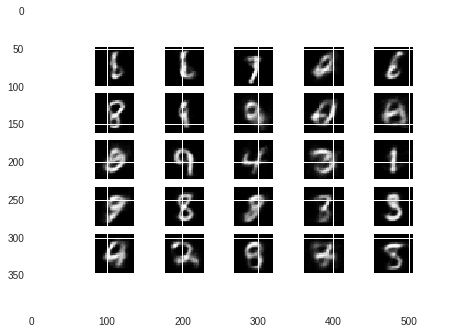

In [25]:
img=mpimg.imread('mnist_9800.png')
imgplot = plt.imshow(img)

In [0]:
import os
a= []
for i in os.listdir() :
    if i.find("mnist") is not -1 :
        a.append(i)

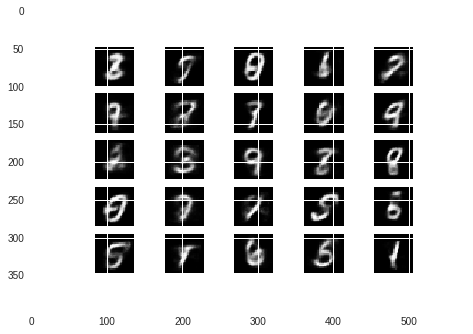

In [36]:
img=mpimg.imread('mnist_12200.png')
imgplot = plt.imshow(img)

In [0]:
img=mpimg.imread('mnist_2600.png')
imgplot = plt.imshow(img)

In [0]:
img=mpimg.imread('mnist_2600.png')
imgplot = plt.imshow(img)